In [1]:
""" Faraz Hossein-Babaei   starting 2016/9/26   Eexperiment 1 with python and pandas:
Correlating economies and medal winnings of countries """
""" Data Reading Segment: Reads dataframe from GDP source table and cleans up the table """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Read large large cluster table (has info about gdp, pop, gender, internet users, hospital goers, ...), and clean it
econ_df = pd.read_csv("..\countries_econ.csv", index_col=2)
econ_df.index.name = None
new_cols = econ_df.columns.values
new_cols[0] = "Series Name"
for i in range(3,len(new_cols)):
    new_cols[i] = int(new_cols[i].split(" ")[0])
econ_df.columns = new_cols

# Now, groupby sub-parts of the complex table to isolate tables of interest
econ_df_groupby = econ_df.groupby(econ_df["Series Name"], axis=0)
gdp_df = econ_df_groupby.get_group("GDP (current US$)")
gdp_df = gdp_df.drop(["Series Name","Series Code","Country Code"], axis=1)
gdp_df = gdp_df.replace(to_replace="..", value=0)
gdp_df = gdp_df.astype(float)
gdp_df = gdp_df.replace(to_replace=0, value=np.nan)
pop_df = econ_df_groupby.get_group("Population, total")
pop_df = pop_df.drop(["Series Name","Series Code","Country Code"], axis=1)
pop_df = pop_df.replace(to_replace="..", value=0)
pop_df = pop_df.astype(float)   # had to go cast as float first bcs skipping that step raised error for non-int poplations
pop_df = pop_df.astype(int)     # oddly, columns with NaN therein stay as float64
pop_df = pop_df.replace(to_replace=0, value=np.nan)


In [20]:
""" Plot Preparation Function Segment: A helper function for drawing graphs to make code shorter """

def prepare_plot (knd, ax, df, ttl, x_lbl, y_lbl, x_tick_lbls, lgd_lbls, clr_map, \
                  ln_styl, ln_wd, mrk, mrk_sz, atten, txt_bool, x_x, idxs):
    """ Function to plot a DataFrame. Each row is plotted as a curve in cartesian
     coordinates. .columns forms x-axis values. """
    
    font = {'font.family':'Arial', 'font.weight':'normal', 'font.size':22}
    
    color_map = clr_map   # matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
    clrs_dict = {}   # other color maps: brg, spectral, Accent, Paired, gnuplot, bone, hsv, jet, gist_ncar
    num_plots = len(idxs)
    cnt = 0
    for idx in idxs:   # Building dict of colors: traversing all unique indices of the df(s) in the data to plot
        cur_num = 1.0*cnt / float(num_plots)
        if cur_num > 1: cur_num -= 1
        clrs_dict[idx] = color_map( cur_num )
        cnt += 1
    
    plt.rcParams.update(font)
    
    for _,idx in enumerate(df.index):
        ax.plot( df.loc[idx,:], color=clrs_dict[idx], linewidth=ln_wd, linestyle=ln_styl, marker=mrk, \
                  markerfacecolor=clrs_dict[idx], markersize=mrk_sz, alpha=atten)
    
    plt.suptitle(ttl, fontsize=36)
    plt.xlabel(x_lbl)
    plt.ylabel(y_lbl)
    plt.ylim(bottom=0)
    plt.xlim(df.columns[0]+x_x[0], df.columns[-1]+x_x[1])
    plt.xticks(df.columns, x_tick_lbls, rotation='vertical')
    
    if len(lgd_lbls) > 0:
        legend = plt.legend( lgd_lbls, ncol=1, loc='best', fontsize=16, \
                   columnspacing=1.5, labelspacing=0.5, handletextpad=0.5, handlelength=1.5, \
                   fancybox=True, shadow=True )
    
    return ax


In [3]:
""" Segment of reformatting economy tables to match the Olympics tables formats """

# Read table used for mapping country names (Olympics or econ format) to IOC codes
ioc_df = pd.read_csv("ioc country codes corrected.tsv", sep='\t', index_col=4)   # col 0 is Country names

# Here, we convert index of country names to one of IOC (3-letter codes) matching our Olympics tables' formats
gdp_df["Country"] = gdp_df.index   # This col is for later IOC indexing the table
pop_df["Country"] = gdp_df.index   # This col is for later IOC indexing the table
gdp_df["IOC"] = gdp_df["Country"].map(ioc_df["IOCode"])   # Derive NOC codes from name and set_index
pop_df["IOC"] = pop_df["Country"].map(ioc_df["IOCode"])   # Derive NOC codes from name and set_index
gdp_df["IOC"].fillna(gdp_df["Country"], inplace=True)
pop_df["IOC"].fillna(pop_df["Country"], inplace=True)
gdp_df.set_index(gdp_df["IOC"], inplace=True)
pop_df.set_index(pop_df["IOC"], inplace=True)
gdp_df.index.name, pop_df.index.name = None, None
gdp_df.drop(["Country","IOC"], axis=1, inplace=True)
pop_df.drop(["Country","IOC"], axis=1, inplace=True)

# Define metrics for economy shares across globe tables of global shares of gdp and population each year
gdp_share_df = gdp_df / gdp_df.sum(axis=0)
pop_share_df = pop_df / pop_df.sum(axis=0)   # This isn't used for the correlation analysis. It is a cool table in itself though.
# Now, create new metrics: the gdp/pop ratios of different degrees for empirical observation
pw = [1, 0.5, 0.2]   # Powers to excite population to before dividing gdp by it
gdppc1_df = gdp_df / (pop_df**pw[0])   # When operating among the dfs, I assume not only they have same size, but also same index
gdppc2_df = gdp_df / (pop_df**pw[1])
gdppc3_df = gdp_df / (pop_df**pw[2])
gdppc1_share_df = gdp_df / (pop_df**pw[0] * gdppc1_df.sum(axis=0))
gdppc2_share_df = gdp_df / (pop_df**pw[1] * gdppc2_df.sum(axis=0))
gdppc3_share_df = gdp_df / (pop_df**pw[2] * gdppc3_df.sum(axis=0))

# Grouping into bins the data of scores
bins = list(range(1960,2020,4)) # list of years to which data be grouped-averaged; for new column headings too
binned_yrs_idxs = np.digitize(x=gdp_df.columns.values.tolist(), bins=bins, right=True)   # They all have same columns
gdp_df_grpby = gdp_df.groupby(binned_yrs_idxs, axis=1)   # GDPs of countries
pop_df_grpby = pop_df.groupby(binned_yrs_idxs, axis=1)   # Populations of countries
gdp_share_df_grpby = gdp_share_df.groupby(binned_yrs_idxs, axis=1)   # GDPs of countries
pop_share_df_grpby = pop_share_df.groupby(binned_yrs_idxs, axis=1)   # Populations of countries
gdppc1_df_grpby = gdppc1_df.groupby(binned_yrs_idxs, axis=1)   # GDP/population
gdppc2_df_grpby = gdppc2_df.groupby(binned_yrs_idxs, axis=1)   # GDP/(population ^ 0.5)
gdppc3_df_grpby = gdppc3_df.groupby(binned_yrs_idxs, axis=1)   # GDP/(population ^ 1.5)
gdppc1_share_df_grpby = gdppc1_share_df.groupby(binned_yrs_idxs, axis=1)   # GDP/population
gdppc2_share_df_grpby = gdppc2_share_df.groupby(binned_yrs_idxs, axis=1)   # GDP/(population ^ 0.5)
gdppc3_share_df_grpby = gdppc3_share_df.groupby(binned_yrs_idxs, axis=1)   # GDP/(population ^ 1.5)


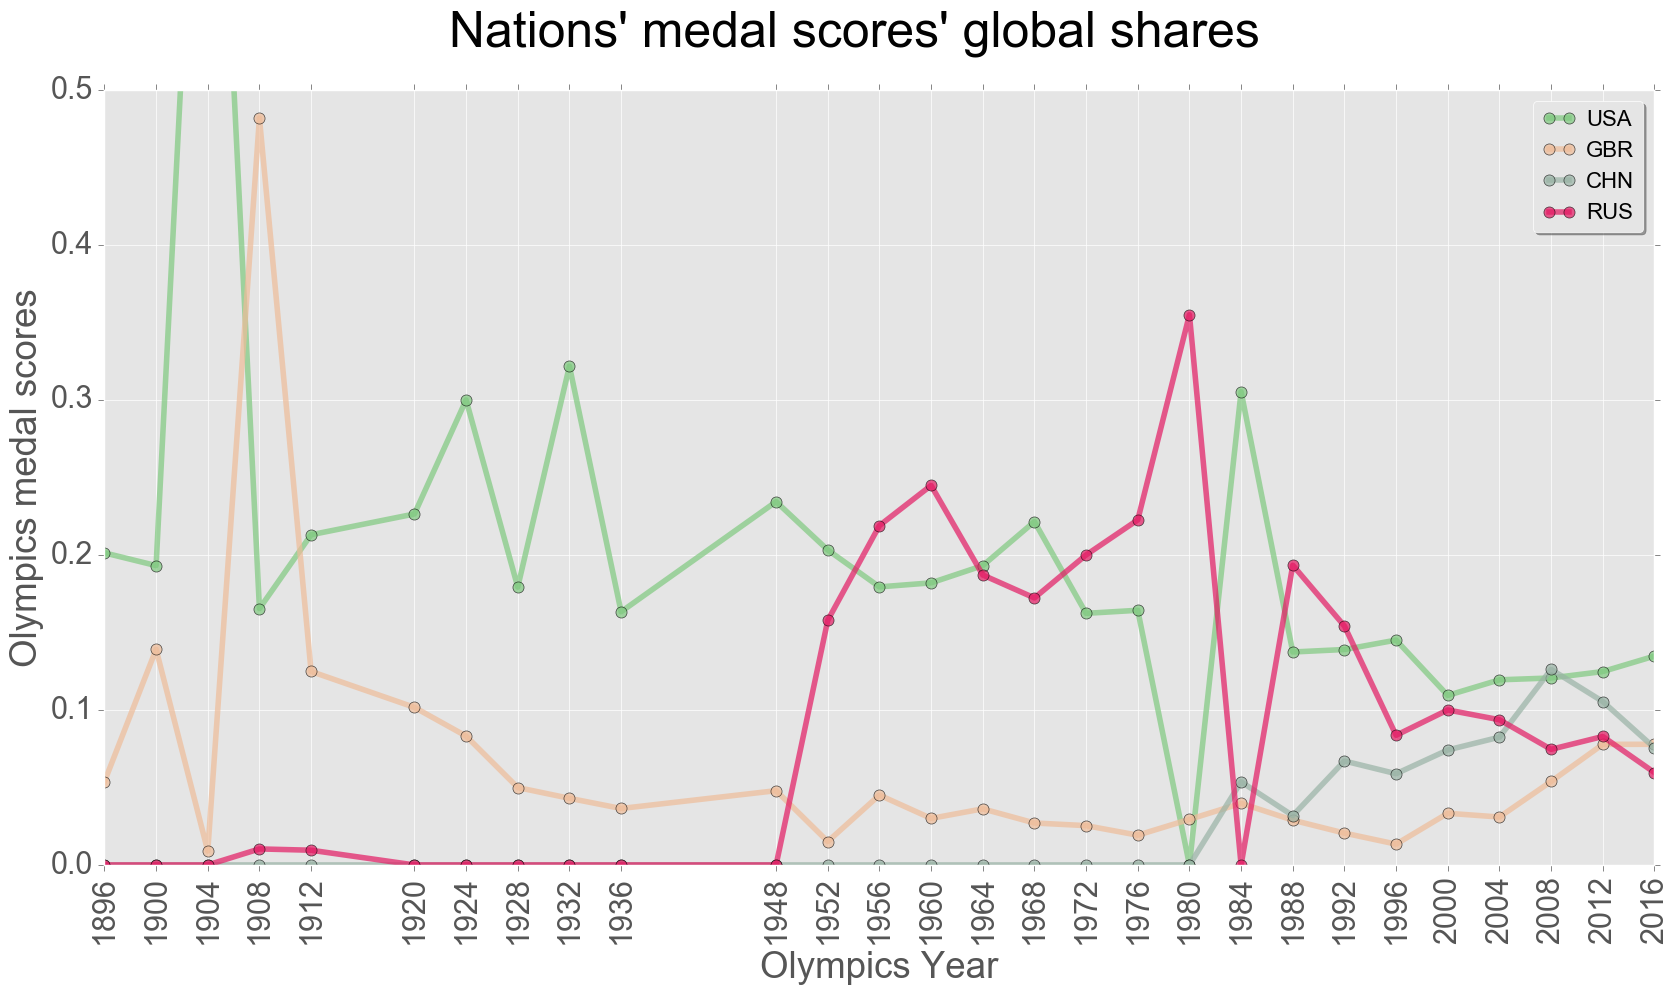

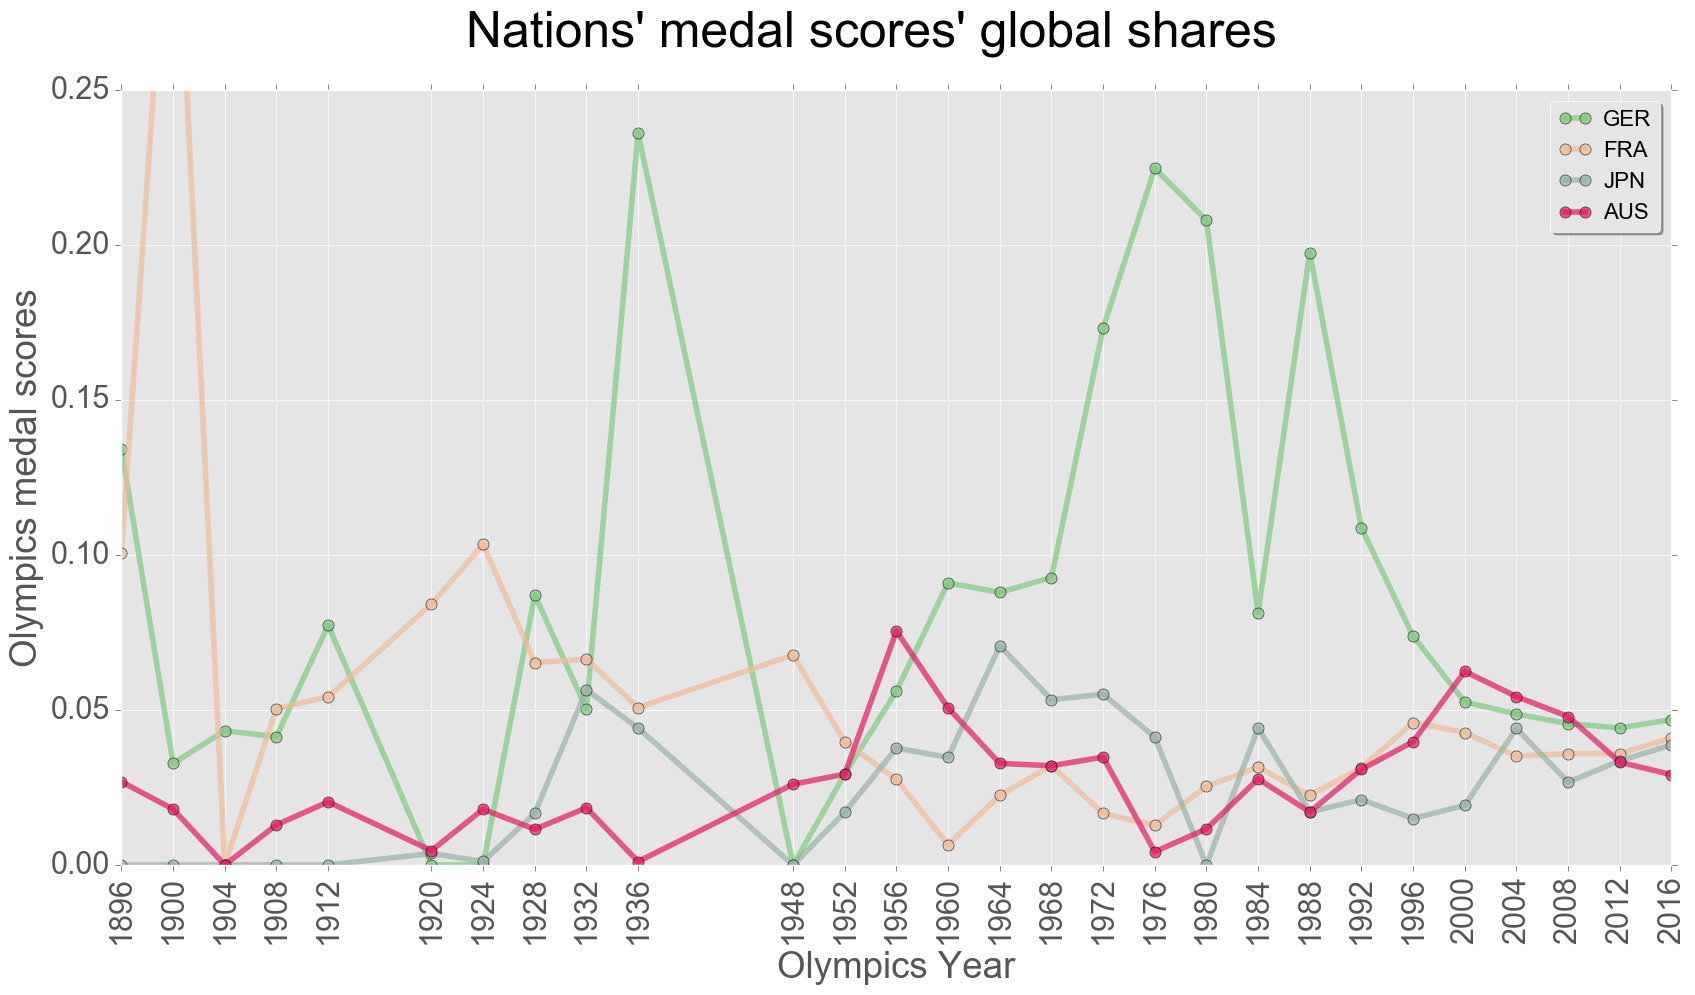

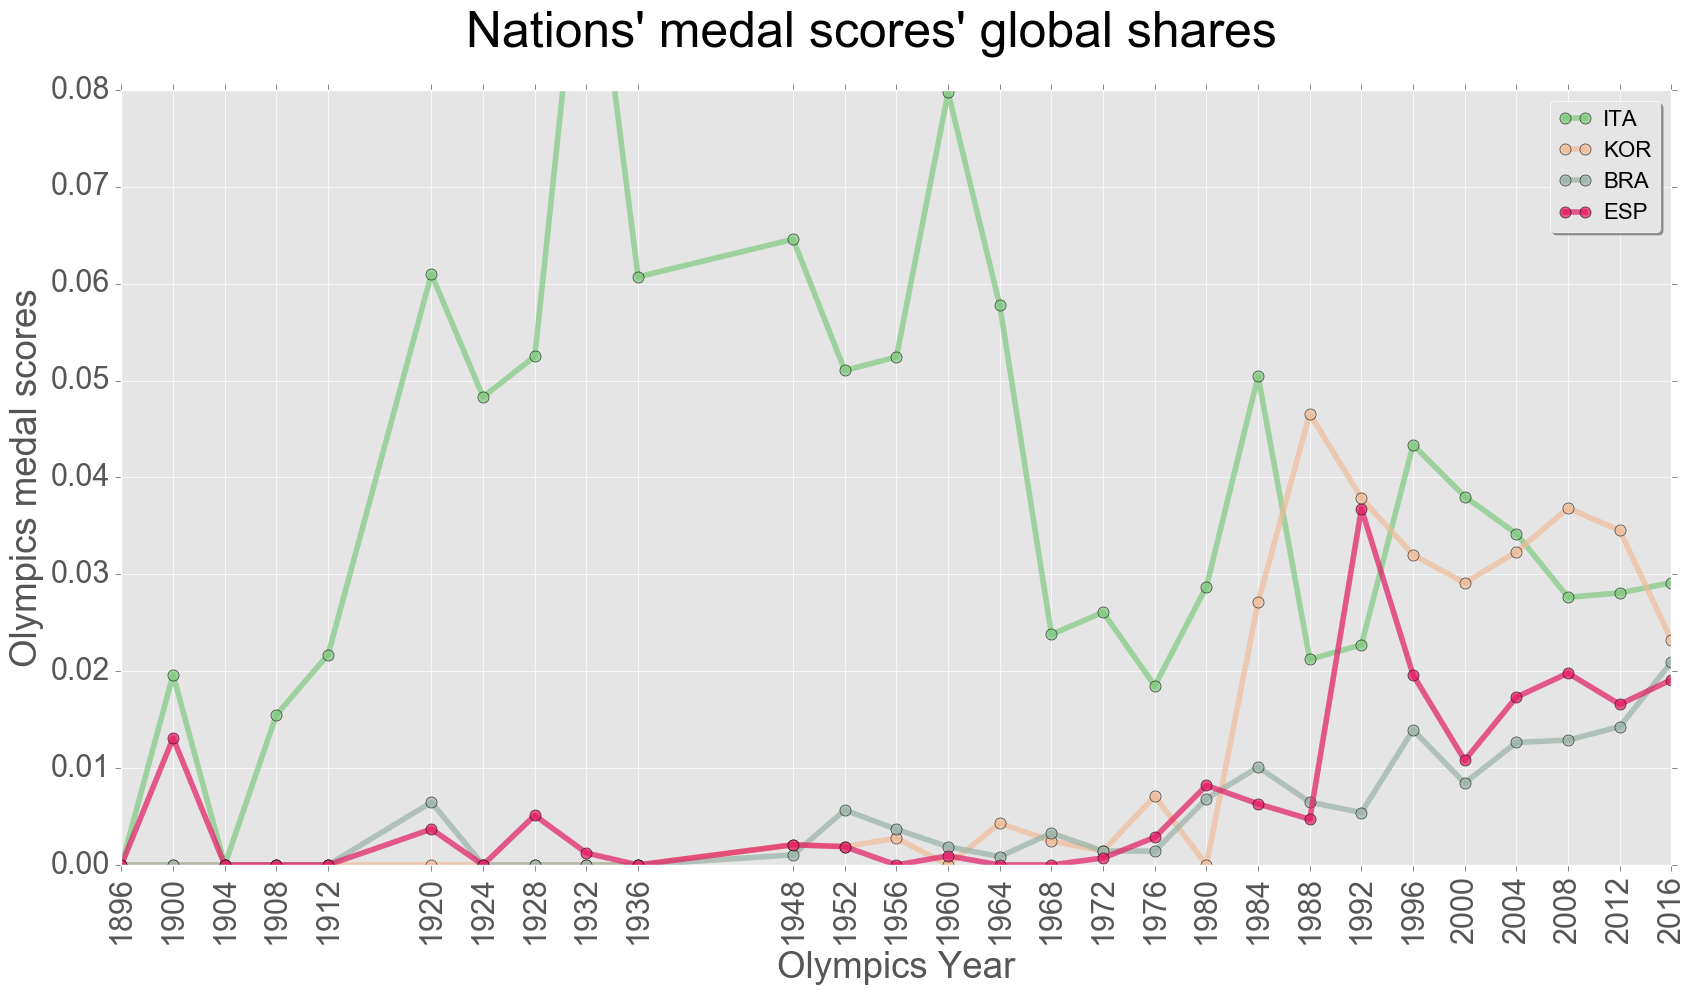

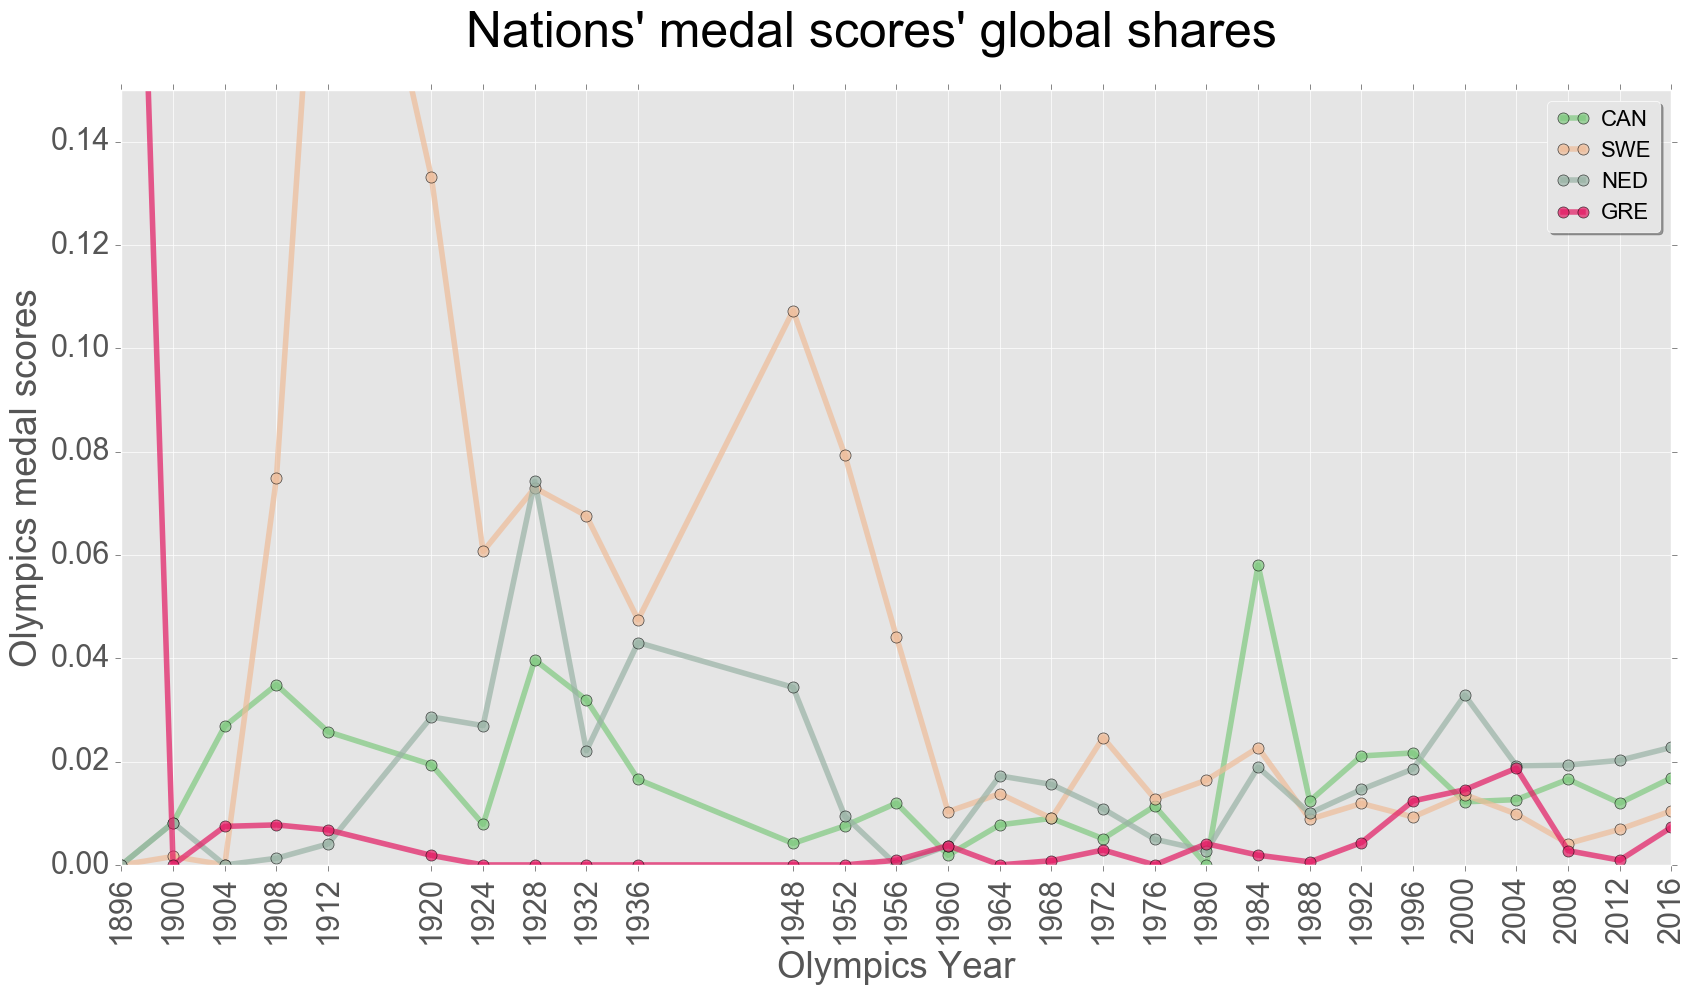

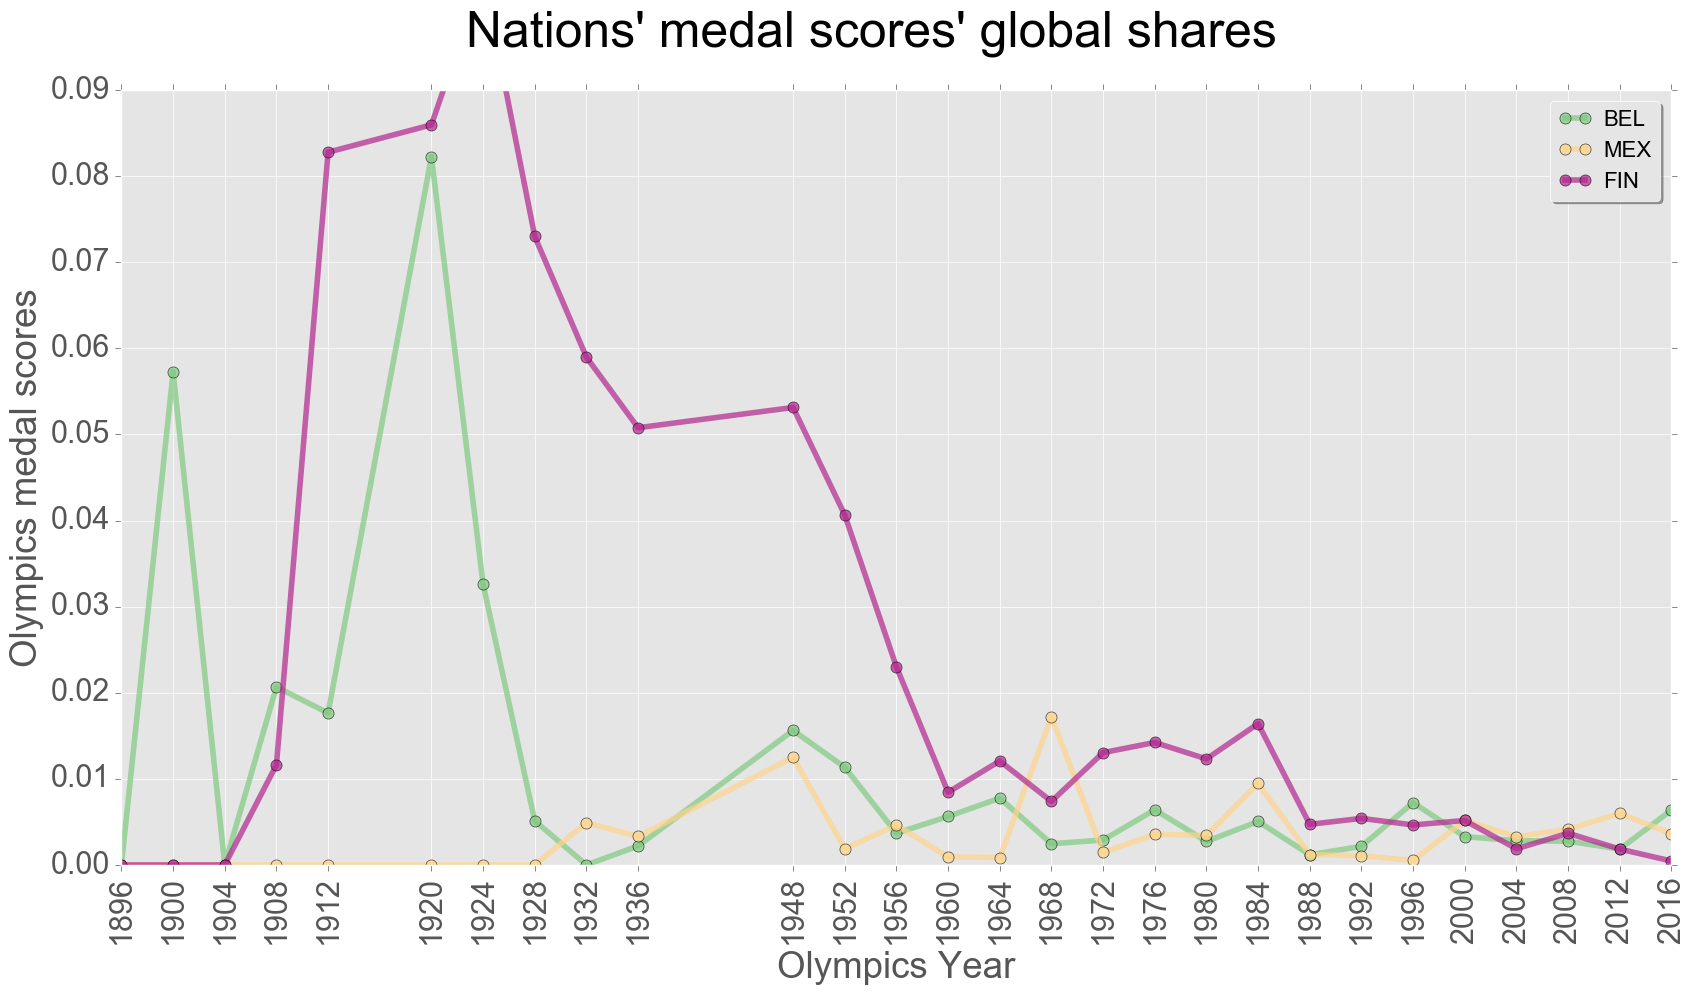

In [21]:
""" Segment for matching Olympics and GDP data formats """

# Read table used for mapping country names (Olympics or econ format) to IOC codes
medal_scores_df = pd.read_csv("all_ctrs_df.csv", index_col=0)
medal_shares_df = pd.read_csv("all_shares_df.csv", index_col=0)

# Loading Olympics data from files prepared from medals_gdp_2.ipynb
all_ctrs_df = pd.read_csv("all_ctrs_df.csv", index_col=0)
all_shares_df = pd.read_csv("all_shares_df.csv", index_col=0)
# Olympics data column headings to int
all_ctrs_df.columns = [int(x) for x in all_ctrs_df.columns.values.tolist()]
all_shares_df.columns = [int(x) for x in all_shares_df.columns.values.tolist()]

# Plotting 1896-2016 Olympics medal score shares data
all_shares_cmplt_df = all_shares_df
all_shares_cmplt_top_df = all_shares_cmplt_df.sort_values([2016,2004], ascending=[False,False])
olymp_yrs = all_shares_cmplt_df.columns.values.tolist()

# select_ctrs_df: Plotting temporal medal trends as countries' medal scores
#olymp_info = pd.read_csv("olymp_host_info.csv", index_col=0)
#hosts = olymp_info["Host Country"].tolist()
hosts = ["USA","GBR","CHN","RUS","GER","FRA","JPN","AUS","ITA","KOR","BRA","ESP","CAN","SWE","NED",\
         "GRE","BEL","MEX","FIN"]
plot_axes = {}
plt.style.use('ggplot')
for i in range(0,5):
    conations = [hosts[j] for j in range(4*i,min(4*i+4,len(hosts)))]
    sub_shares_df = all_shares_cmplt_top_df.loc[conations, :]
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    plot_axes[i] = prepare_plot("line", ax, sub_shares_df, "Nations' medal scores' global shares" , \
                 "Olympics Year" , "Olympics medal scores", \
                 olymp_yrs, sub_shares_df.index , plt.cm.Accent, '-', 4.0, 'o', 8.0, 0.7, \
                 False, (0,0), sub_shares_df.index)

plot_axes[0].set_ybound(upper=0.5)
plot_axes[1].set_ybound(upper=0.25)
plot_axes[2].set_ybound(upper=0.08)
plot_axes[3].set_ybound(upper=0.15)
plot_axes[4].set_ybound(upper=0.09)


# Back to our main point of formatting the Olympic data for correlation with economies
all_ctrs_df = all_ctrs_df.loc[:, 1960:]       # limiting the time to post-1960 to match GDP data
all_shares_df = all_shares_df.loc[:, 1960:]   # limiting the time to post-1960 to match GDP data
# Note: all_ctrs_df, all_shares_df  res files have come from medals_gdp_2 notebook


In [5]:
""" Medal Trends Data preparation Segment: Preparing data for temporal medal trends of countries. """

# Get some output with economically high-ranking nations
g3_4y_share_df = gdppc3_share_df_grpby.mean()
g3_4y_share_df.columns = bins
g3_4y_share_df = g3_4y_share_df.sort_values([2016,2004], ascending=[False,False])
print (g3_4y_share_df[[1960,1996,2016]].head(n=8))   # If they show as basic ints like 0,1,... don't worry. They are float
print ()
# Get some output with Olympics-wise high-ranking nations
all_shares_top_df = all_shares_df.sort_values([2016,2004], ascending=[False,False])
print (all_shares_top_df[[1960,1996,2016]].head(n=8))


      1960   1996   2016
USA 0.3843 0.2032 0.1835
CHN 0.0322 0.0128 0.0812
JPN 0.0358 0.1523 0.0576
GER    nan 0.0802 0.0507
GBR 0.0655 0.0435 0.0415
FRA 0.0581 0.0543 0.0388
ITA 0.0369 0.0427 0.0298
CAN 0.0461 0.0252 0.0282

      1960   1996   2016
USA 0.1820 0.1451 0.1347
GBR 0.0300 0.0134 0.0778
CHN 0.0000 0.0589 0.0756
RUS 0.2448 0.0836 0.0596
GER 0.0910 0.0738 0.0469
FRA 0.0066 0.0459 0.0410
JPN 0.0347 0.0150 0.0387
AUS 0.0507 0.0398 0.0291


In [6]:
""" Simple Plot Preparation Function Segment: for drawing graphs """

def prepare_simple_plot (fig_idx, ax, x_vals, y_vals, ttl, x_lbl, y_lbl, x_tick_lbls, lgd_lbls, clr, \
                  ln_styl, ln_wd, mrk, mrk_sz, atten, idxs, ax_clr):
    """ Function to plot a DataFrame. Each row is plotted as a curve in cartesian
     coordinates. .columns forms x-axis values. """

    font = {'font.family':'Arial', 'font.weight':'normal', 'font.size':22}
    plt.rcParams.update(font)
    
    ax.plot(x_vals, y_vals, color=clr, linewidth=ln_wd, linestyle=ln_styl, marker=mrk, \
            markerfacecolor=clr, markersize=mrk_sz, alpha=atten)
    
    
    plt.suptitle(ttl, fontsize=36)
    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl, color=ax_clr)
    ax.yaxis.label.set_color(ax_clr)
    ax.tick_params(axis='y', colors=ax_clr)
    ax.set_ybound(lower=0)
    ax.set_xbound(x_vals[0], x_vals[-1]+4)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x_tick_lbls, rotation='vertical')
    
    if len(lgd_lbls) > 0:
        legend = ax.legend( lgd_lbls, ncol=2, loc='best', fontsize=16, bbox_to_anchor=[0.7, 0.95], \
                   columnspacing=1.0, labelspacing=0.5, handletextpad=0.0, handlelength=1.5, \
                   fancybox=True, shadow=True )
    
    return


In [7]:
""" Segment for preparing data to plot """

def plot_ctr_gdp_olymp_jux (ctr_grp):
    """ Plotting trends of and fits to economy and Olympics performace shares of nations. """
    
    finite_mask = np.isfinite(g3_4y_share_df.loc[ctr_grp,:].iloc[0,:].tolist())
    xR_expr = g3_4y_share_df.columns.values.tolist()
    xL_expr = [j for i,j in enumerate(xR_expr) if finite_mask[i]]   # applying the bool mask filter
    yL_expr = g3_4y_share_df.loc[ctr_grp,:].iloc[0,:].tolist()
    yL_expr = [j for i,j in enumerate(yL_expr) if finite_mask[i]]
    yR_expr = all_shares_df.loc[ctr_grp,:].iloc[0,:].tolist()
    x_cont = np.linspace(xR_expr[0], xR_expr[-1]+2, 100)   # a[0] is min(a), a[-1] is max(a); sorted!
    xL_cont = np.linspace(xL_expr[0], xL_expr[-1]+2, 100)
    xR1 = [x for x in x_cont if x <= xR_expr[-1]]
    xL1 = [x for x in xL_cont if x <= xL_expr[-1]]
    xL2 = [x for x in xL_cont if x >= xL_expr[-1]-0.5]   # -0.5 to have continuity
    
    # get curve fit functions
    p_fit_L = np.polyfit(xL_expr, yL_expr, deg=5)
    p_fit_R = np.polyfit(xR_expr, yR_expr, deg=5)
    
    COLOR_1 = "#ee7700"
    COLOR_2 = "#77cc22"
    COLOR_1_AX = "#ee7700"
    COLOR_2_AX = "#55bb11"
    COLOR_1_PTS = "#dd8822"
    COLOR_2_PTS = "#99dd00"
    
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    
    # polynomial fit to GDP data
    prepare_simple_plot(1, ax1, xL1, np.poly1d(p_fit_L)(xL1), "" , \
                 "" , "", \
                 g3_4y_share_df.columns, [] , COLOR_1, '-', 4.0, 'None', 10.0, 0.7, \
                 g3_4y_share_df.index, COLOR_1_AX)
    # polynomial fit to Olympic data
    prepare_simple_plot(1, ax2, xR1, np.poly1d(p_fit_R)(xR1), "" , \
                 "" , "", \
                 g3_4y_share_df.columns, [] , COLOR_2, '-', 4.0, 'None', 10.0, 0.7, \
                 g3_4y_share_df.index, COLOR_2_AX)
    # Extrapolating GDP data
    prepare_simple_plot(1, ax1, xL2, np.poly1d(p_fit_L)(xL2), "" , \
                 "" , "", \
                 g3_4y_share_df.columns, [] , COLOR_1, '--', 4.0, 'None', 10.0, 0.7, \
                 g3_4y_share_df.index, COLOR_1_AX)
    # Actual GDP data
    prepare_simple_plot(1, ax1, xL_expr, yL_expr, "" , \
                 "Olympics Year" , "GDP/pop^0.2 global share", \
                 xL_expr, [], COLOR_1_PTS, '', 4, 'o', 10, 0.9, \
                 g3_4y_share_df.index, COLOR_1_AX)
    # Actual Olympics data
    prepare_simple_plot(1, ax2, xR_expr, yR_expr, "Economic and Olympic performances of "+ctr_grp[0] , \
                 "Olympics Year" , "Olympics medal score share", \
                 xR_expr, [], COLOR_2_PTS, '', 4, 'd', 10, 0.9, \
                 all_shares_df.index, COLOR_2_AX)
    
    return [ax1,ax2]


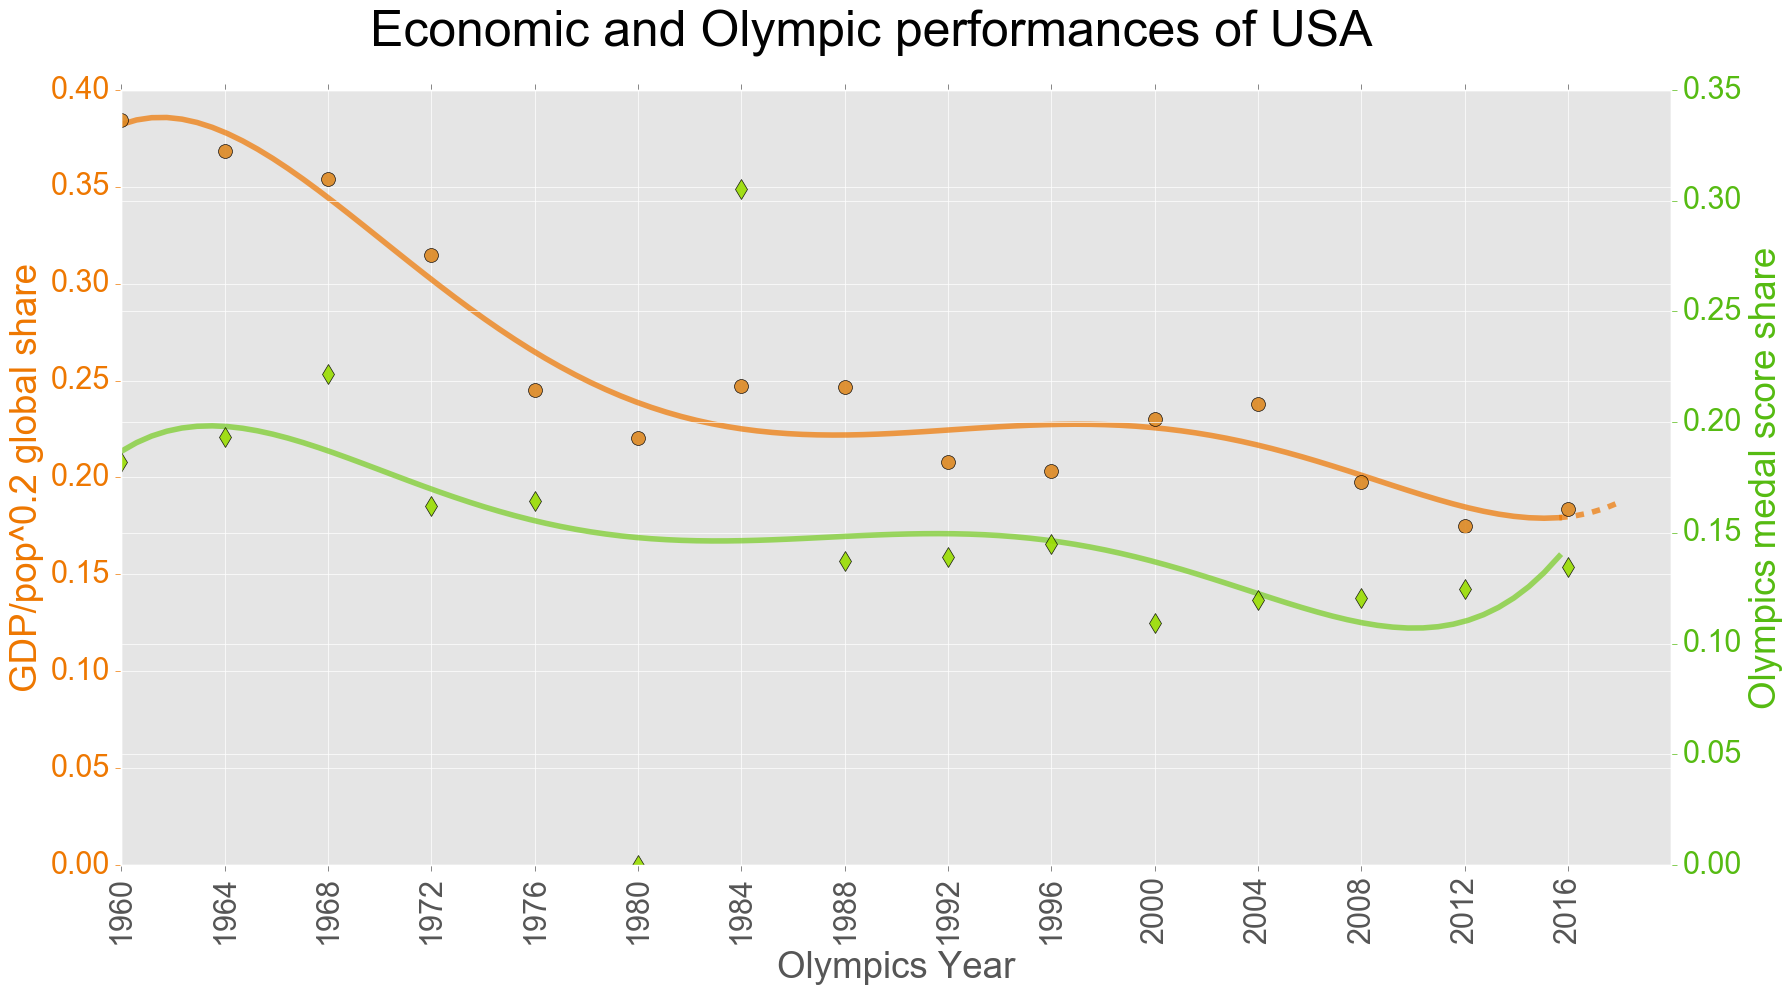

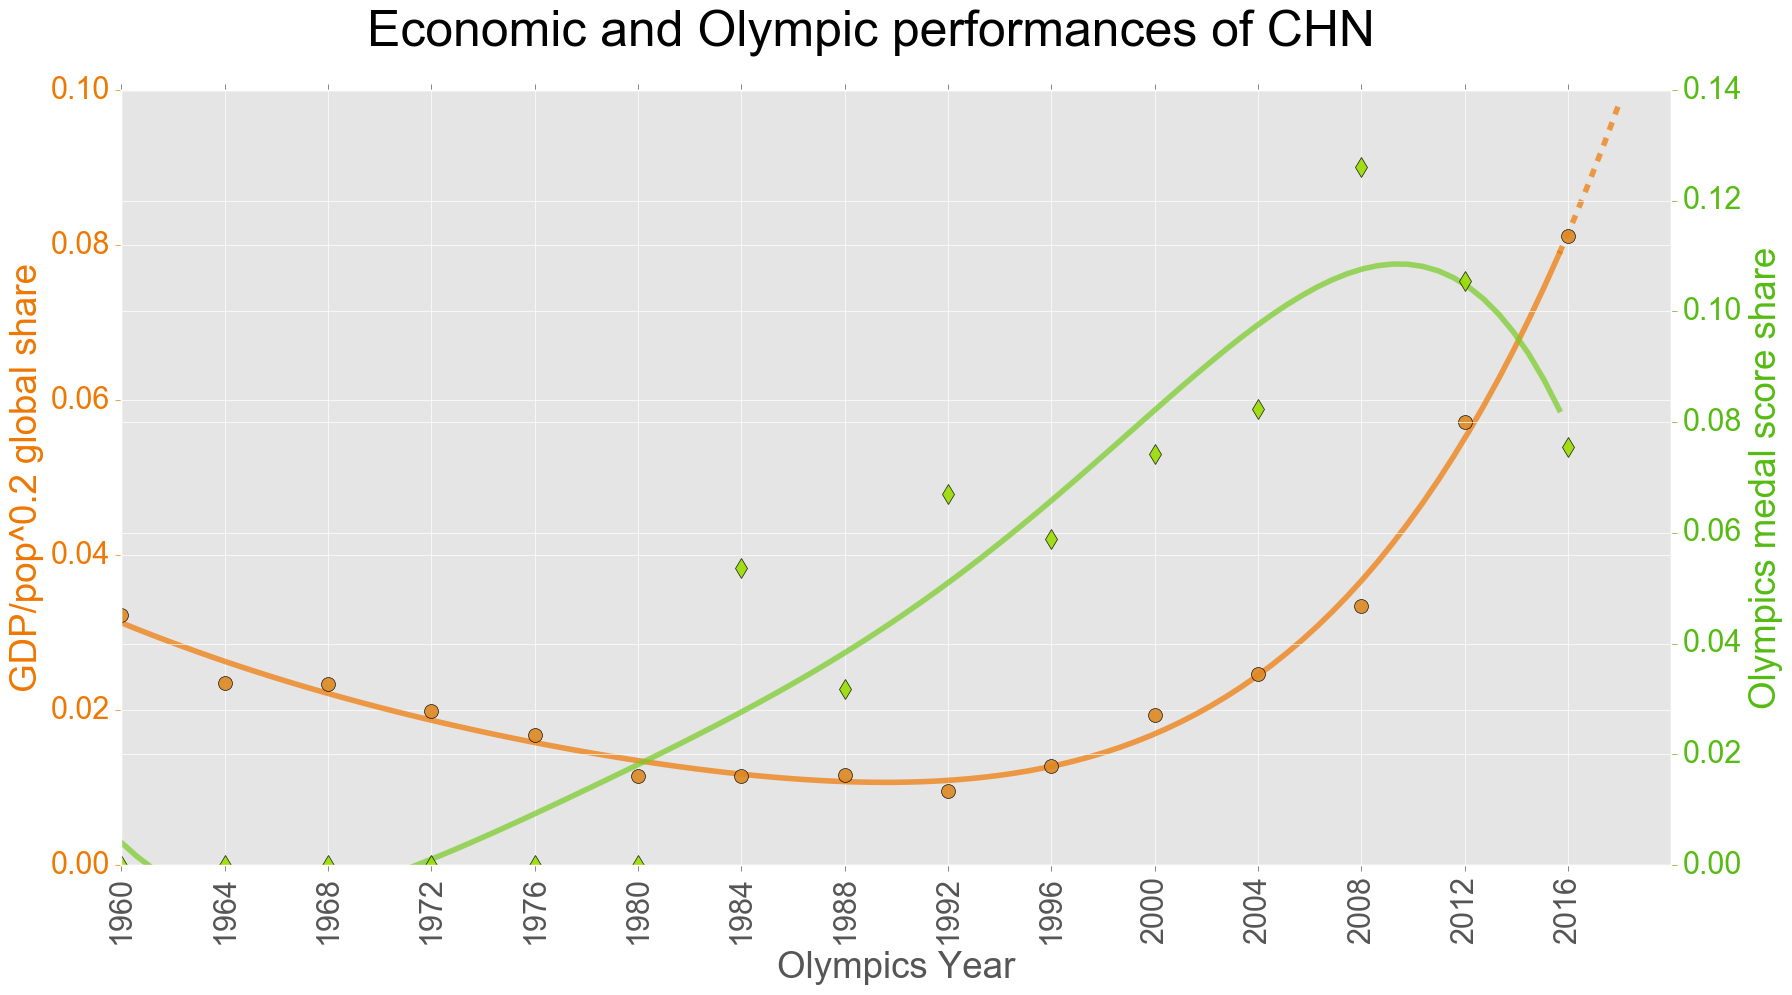

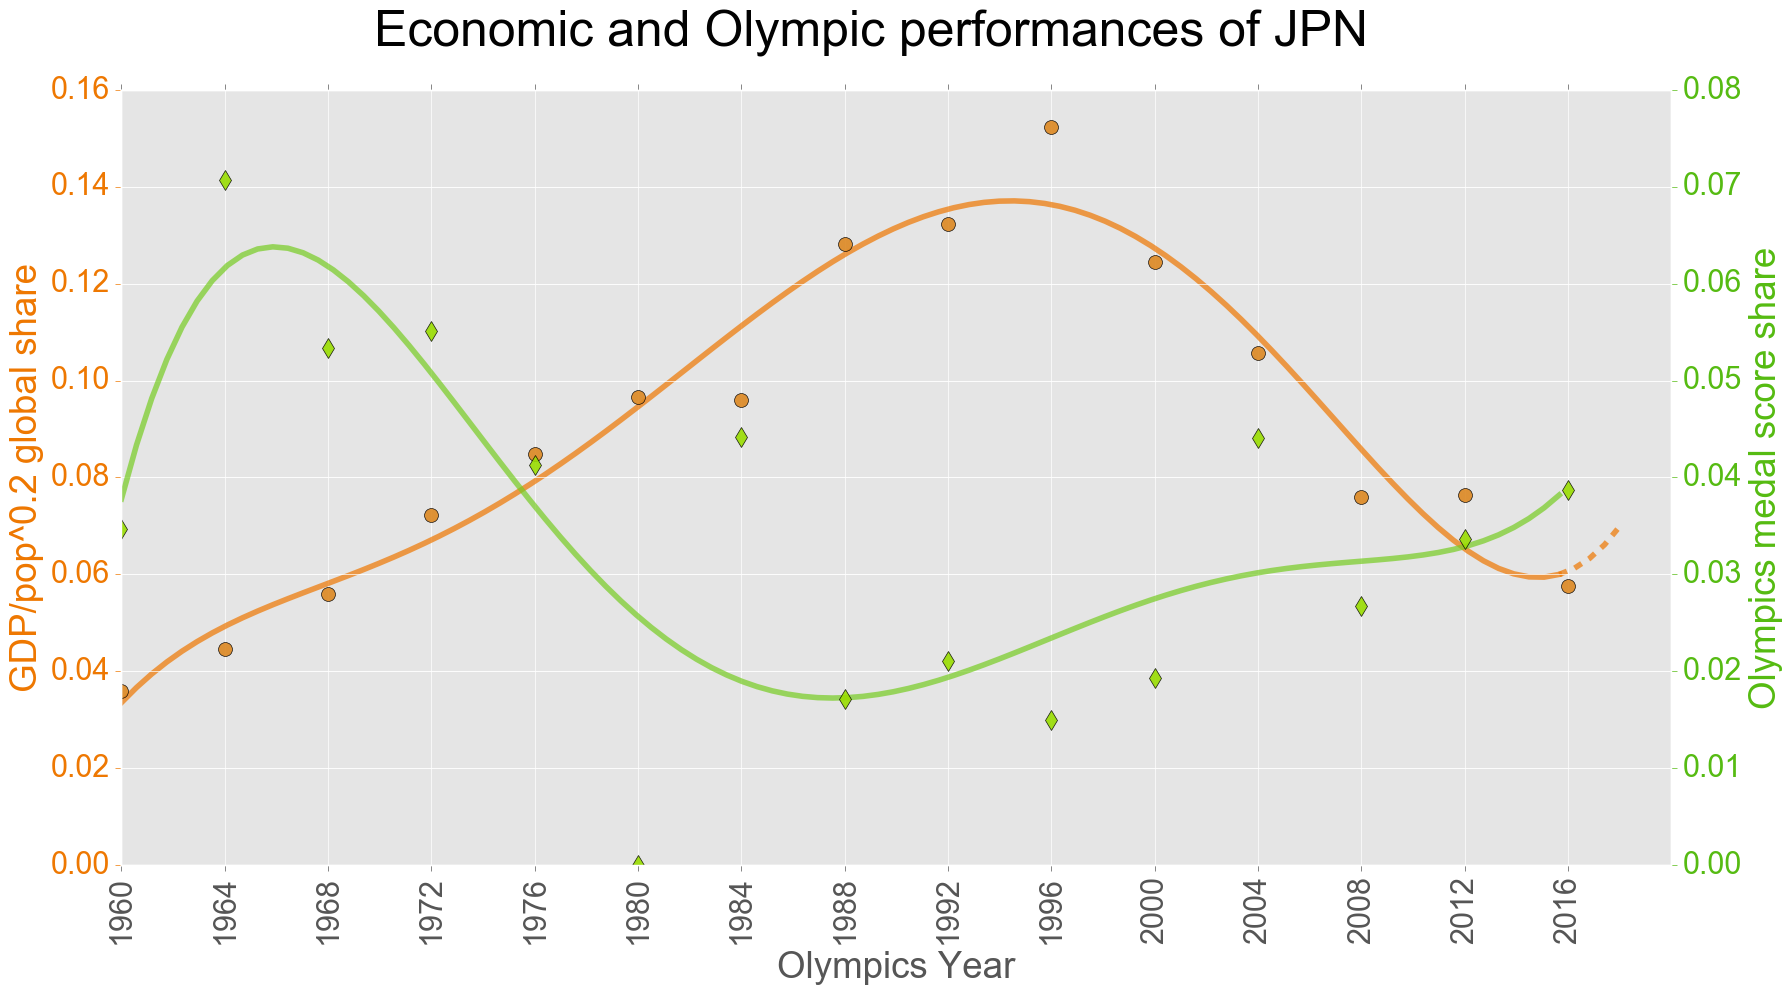

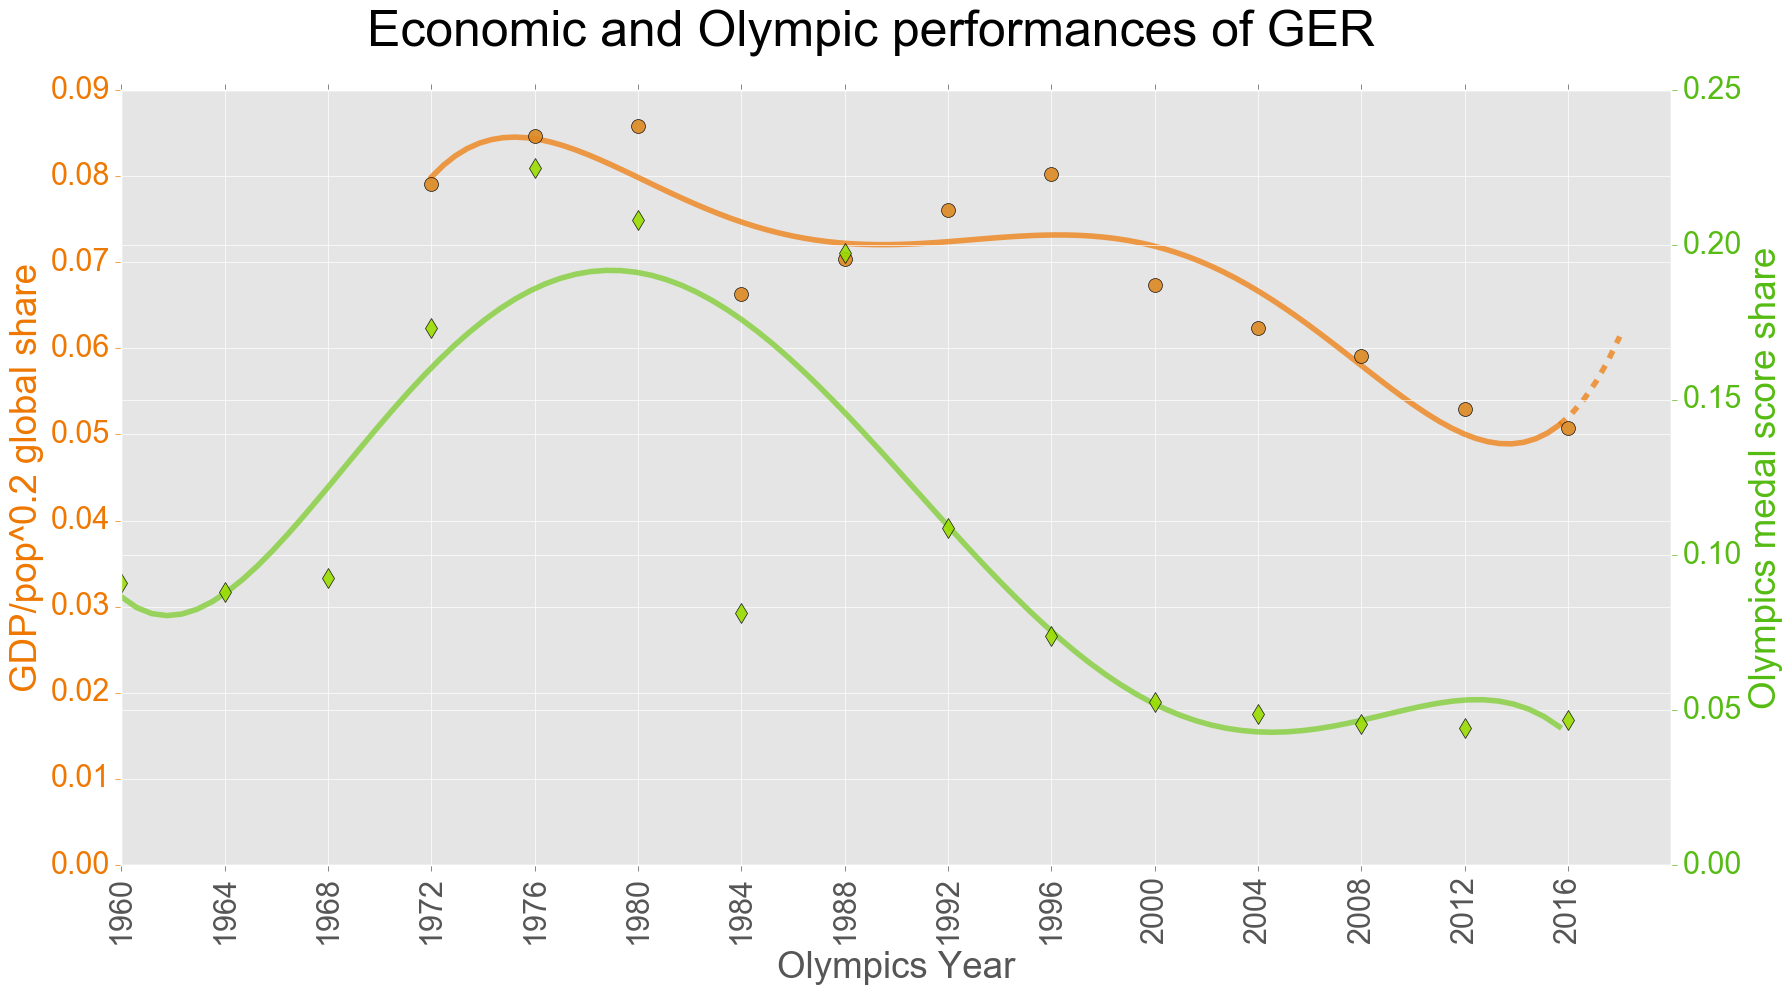

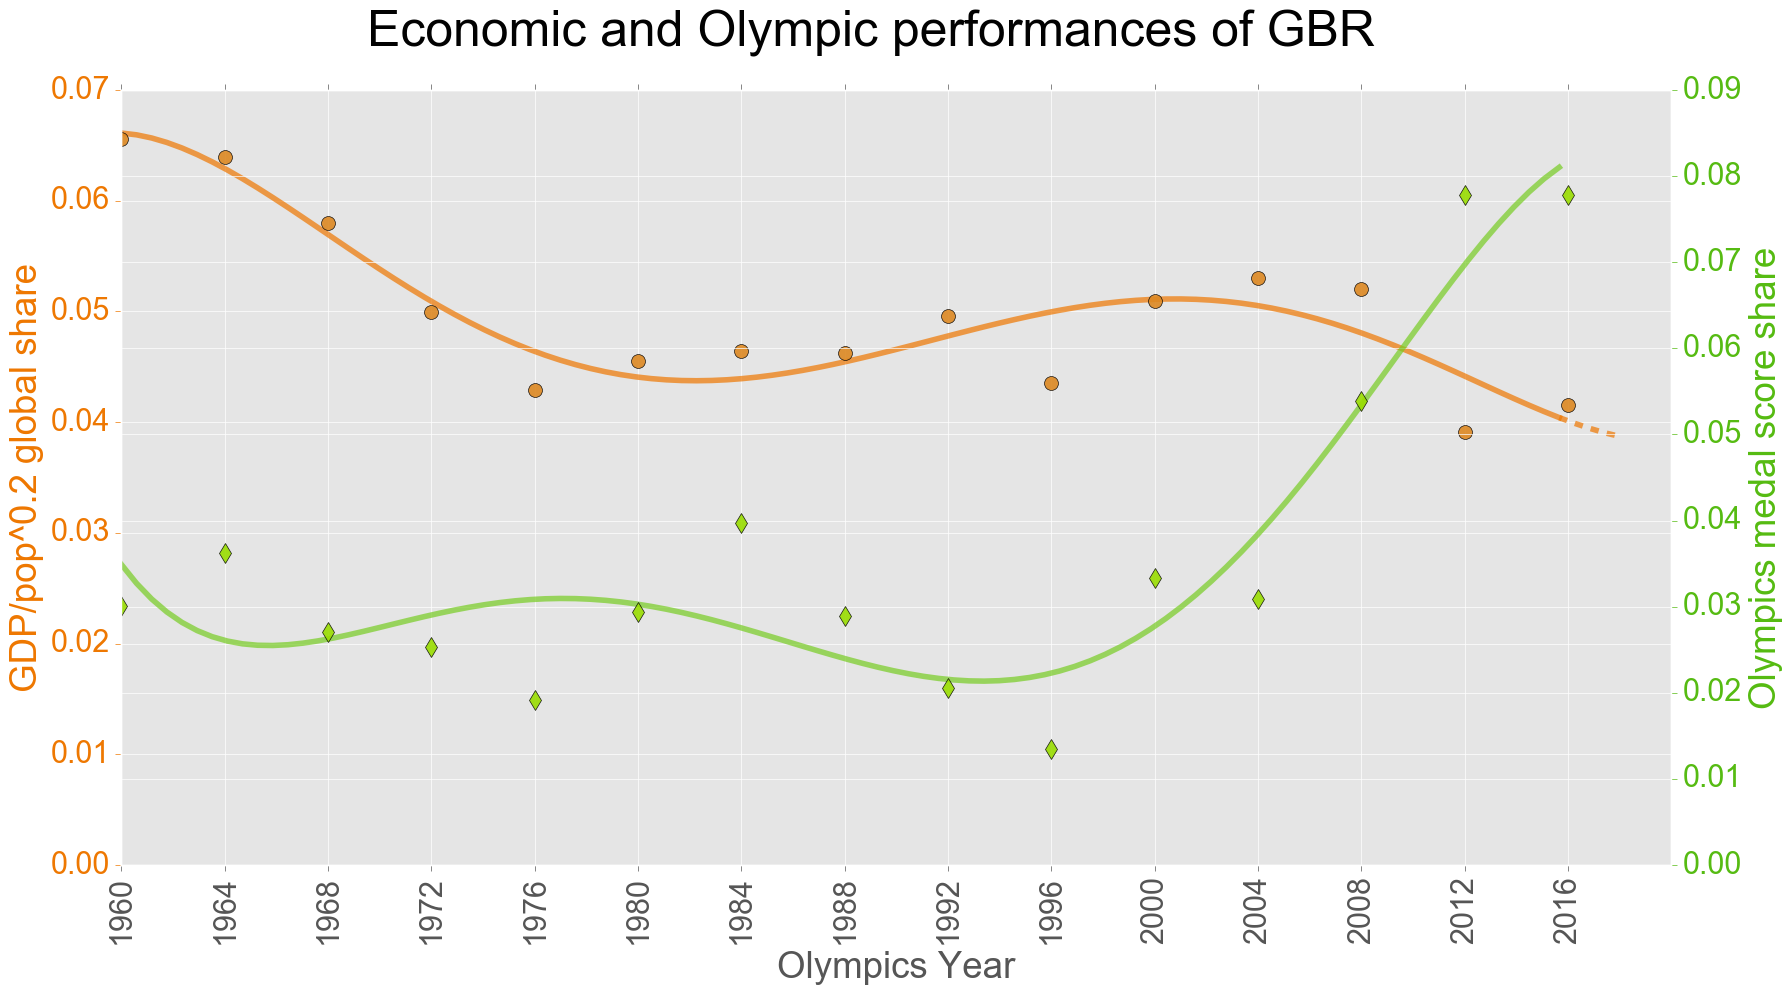

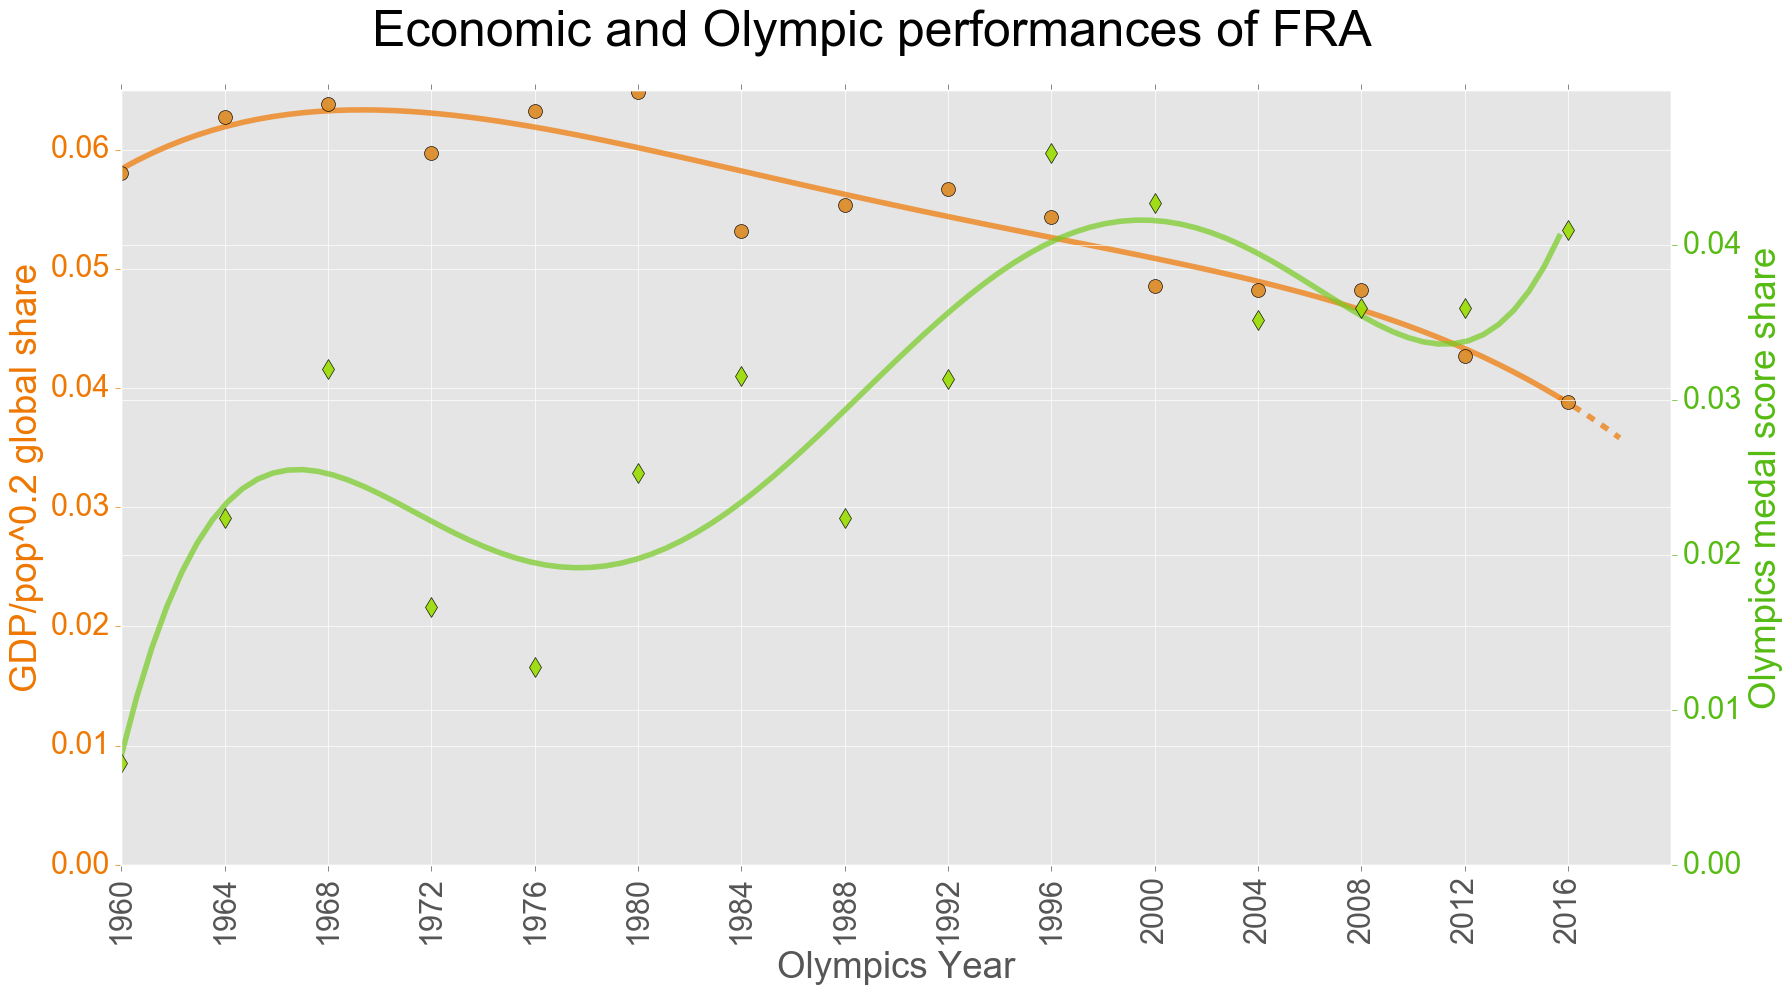

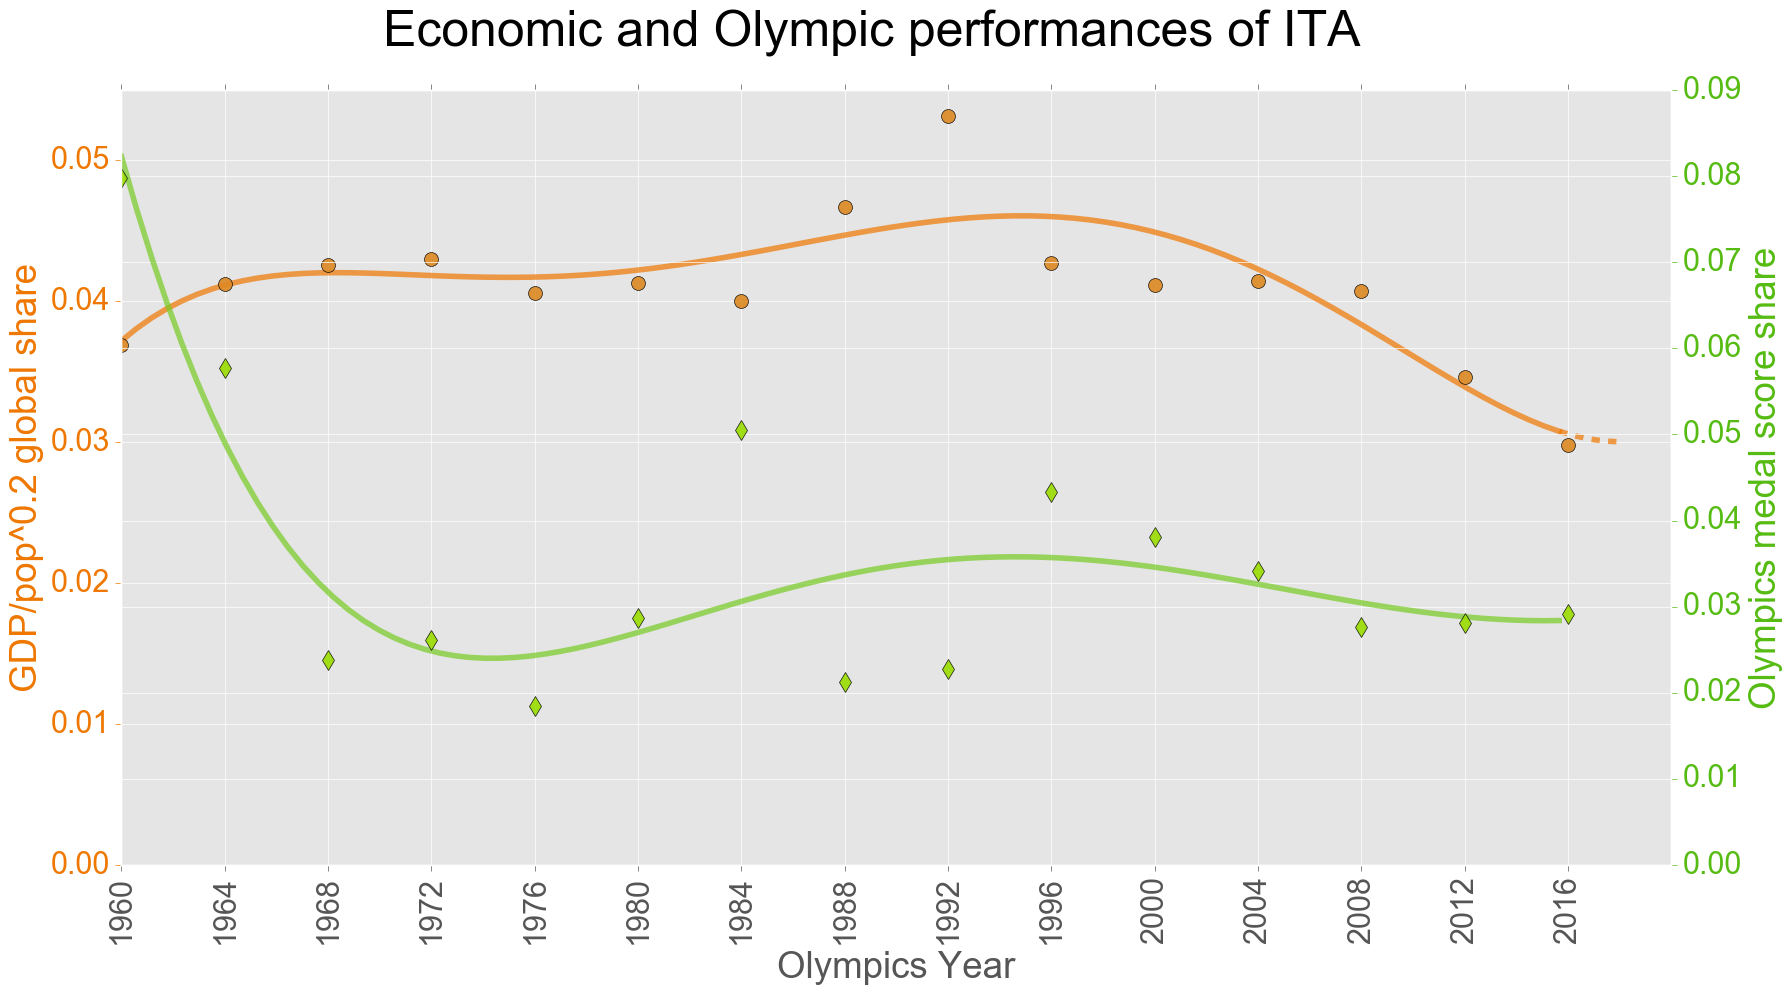

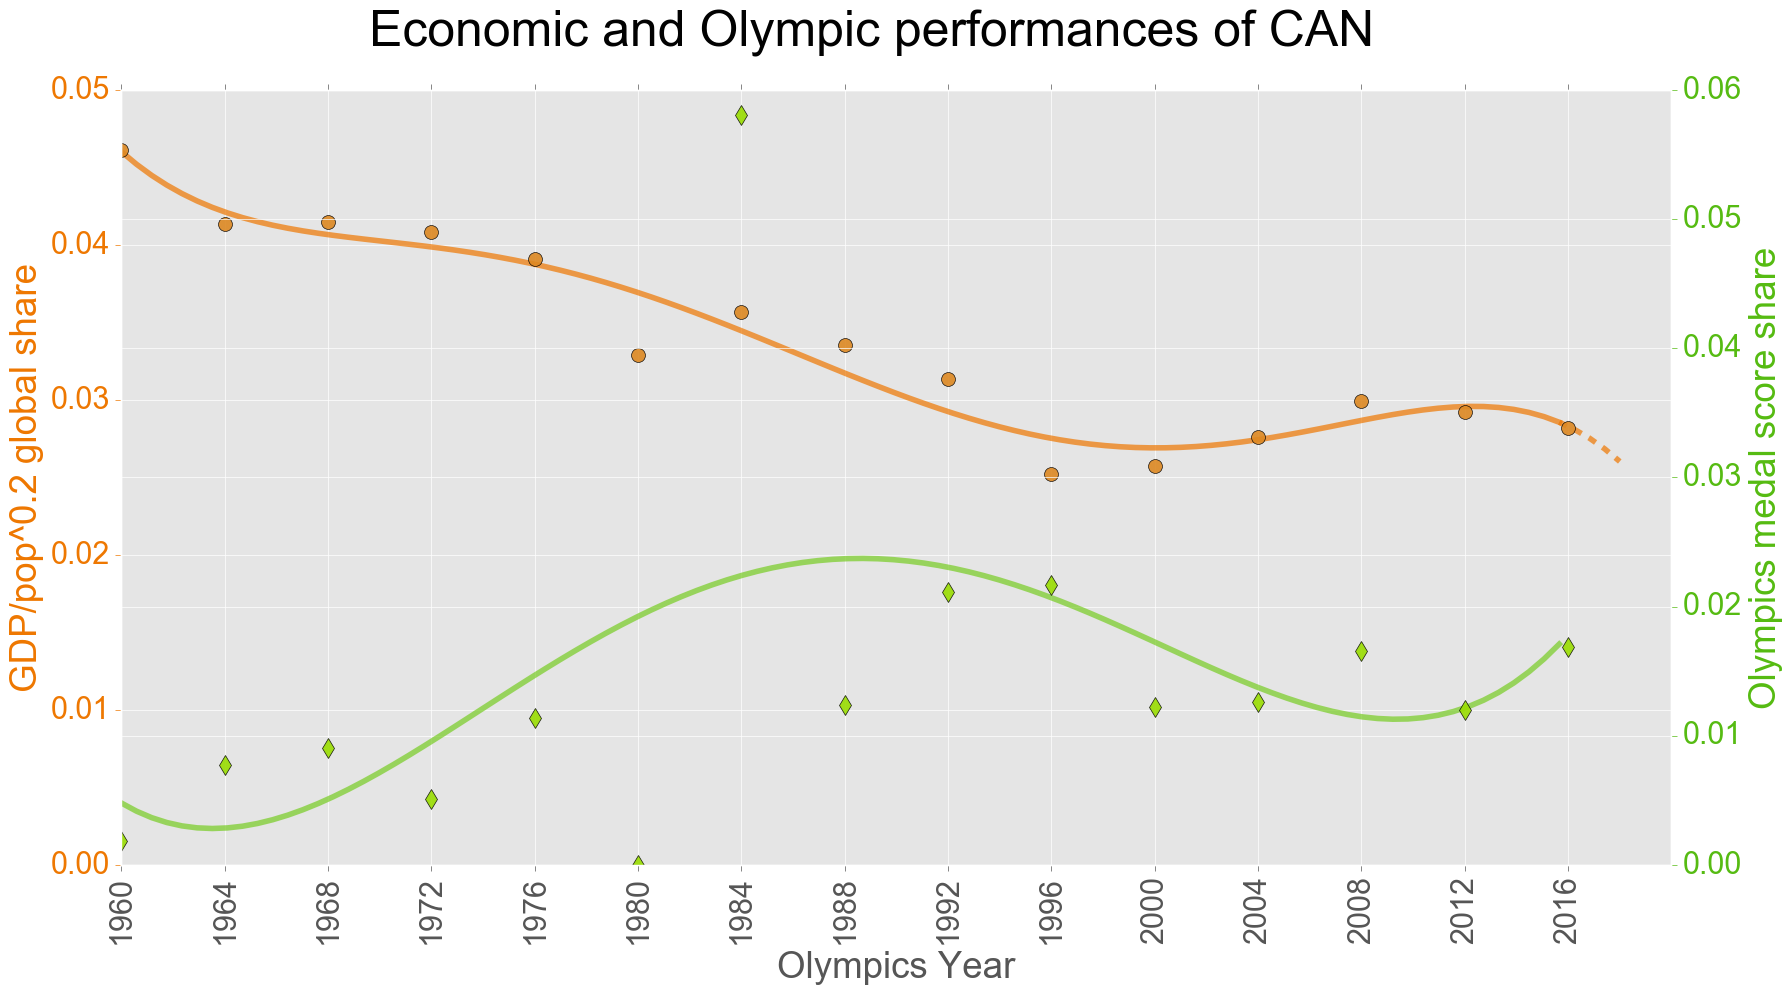

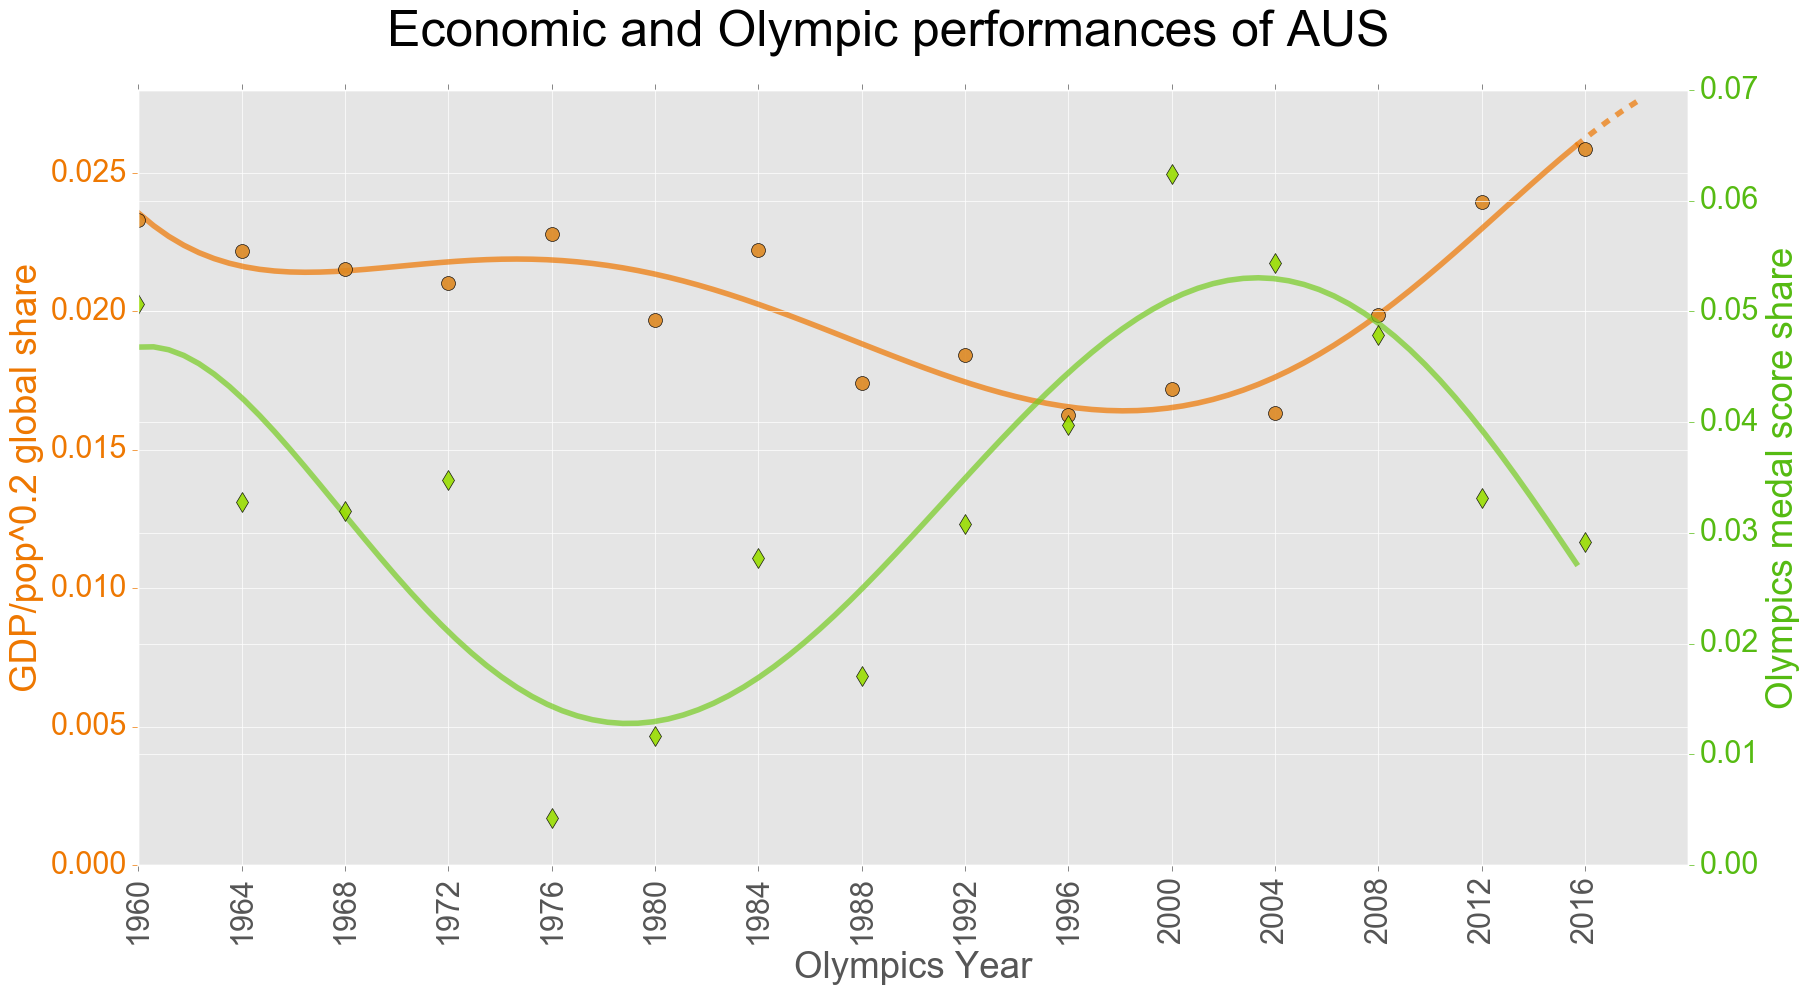

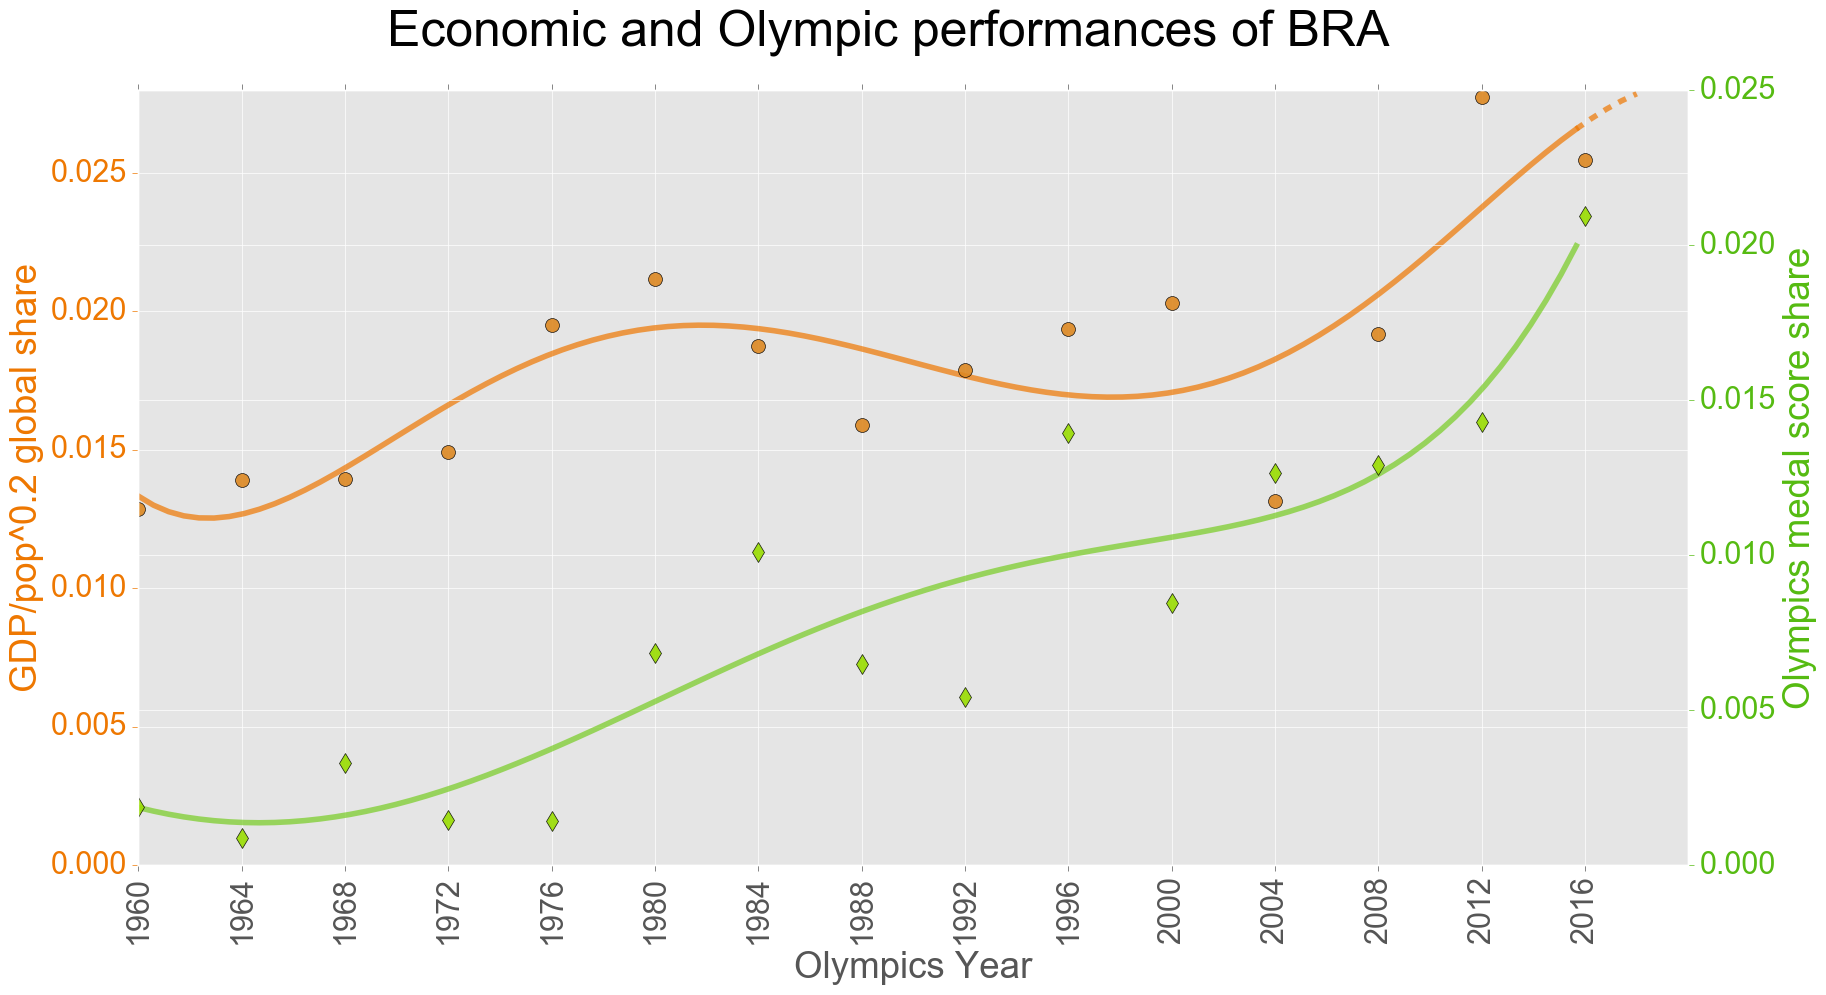

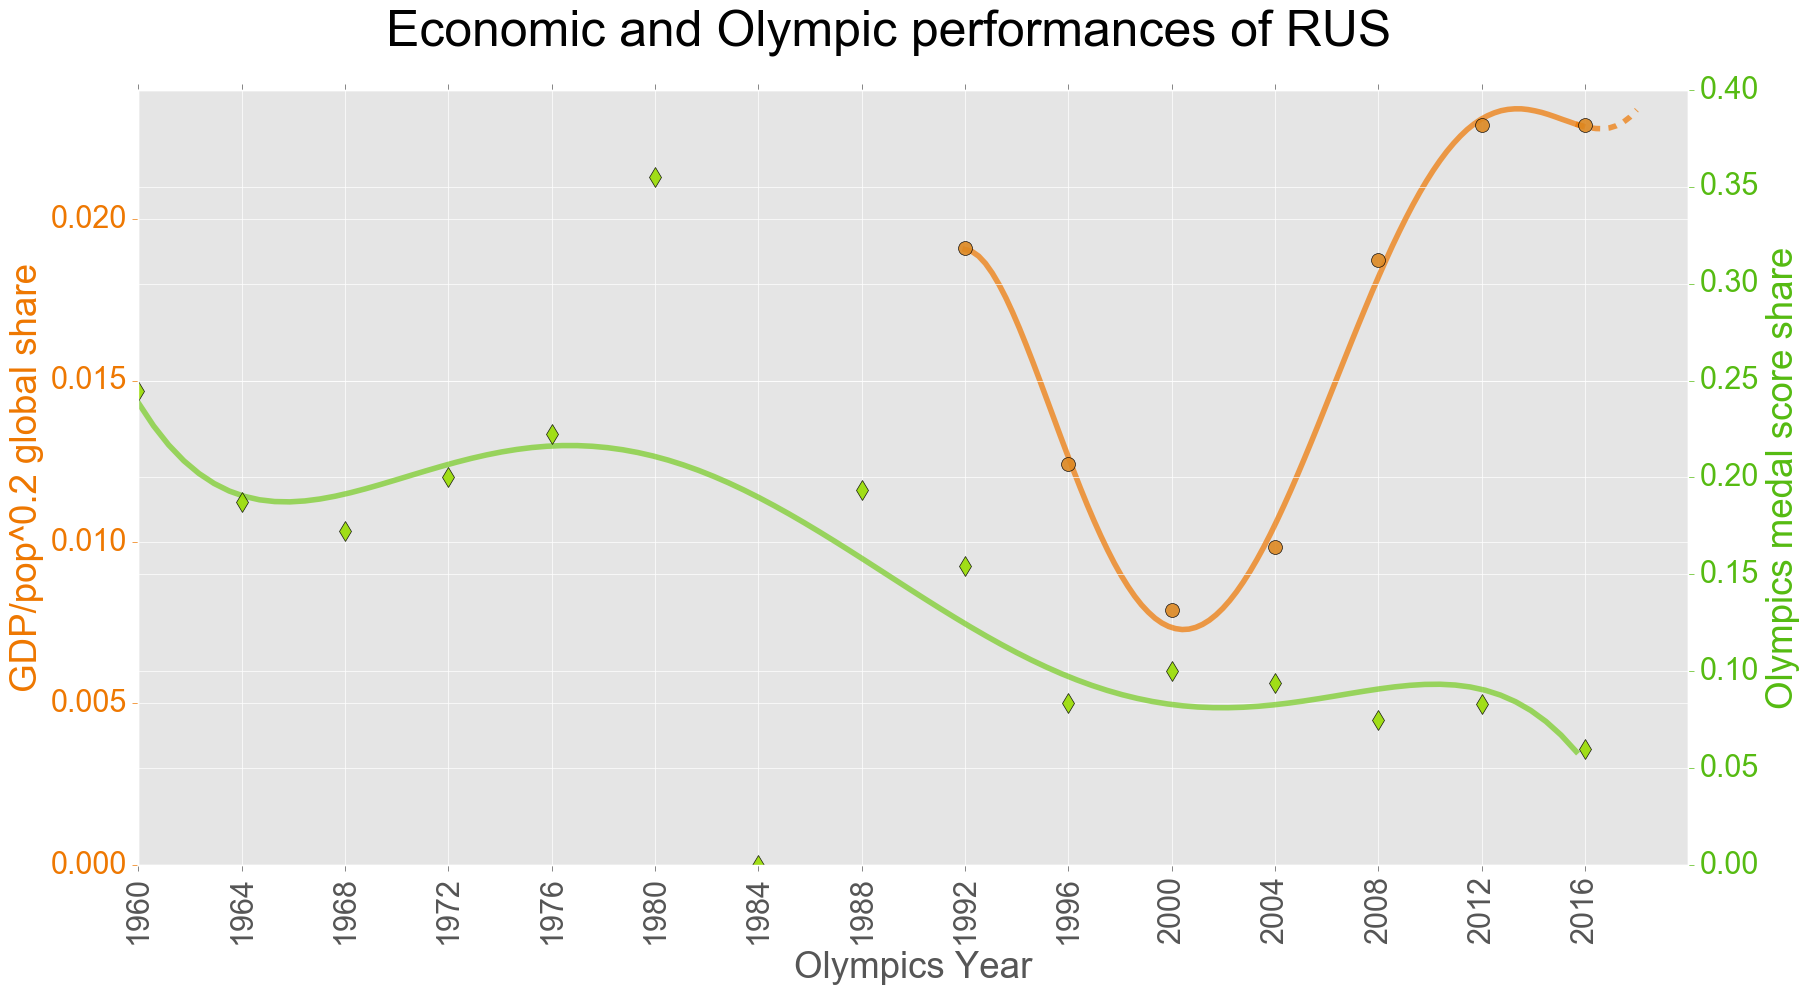

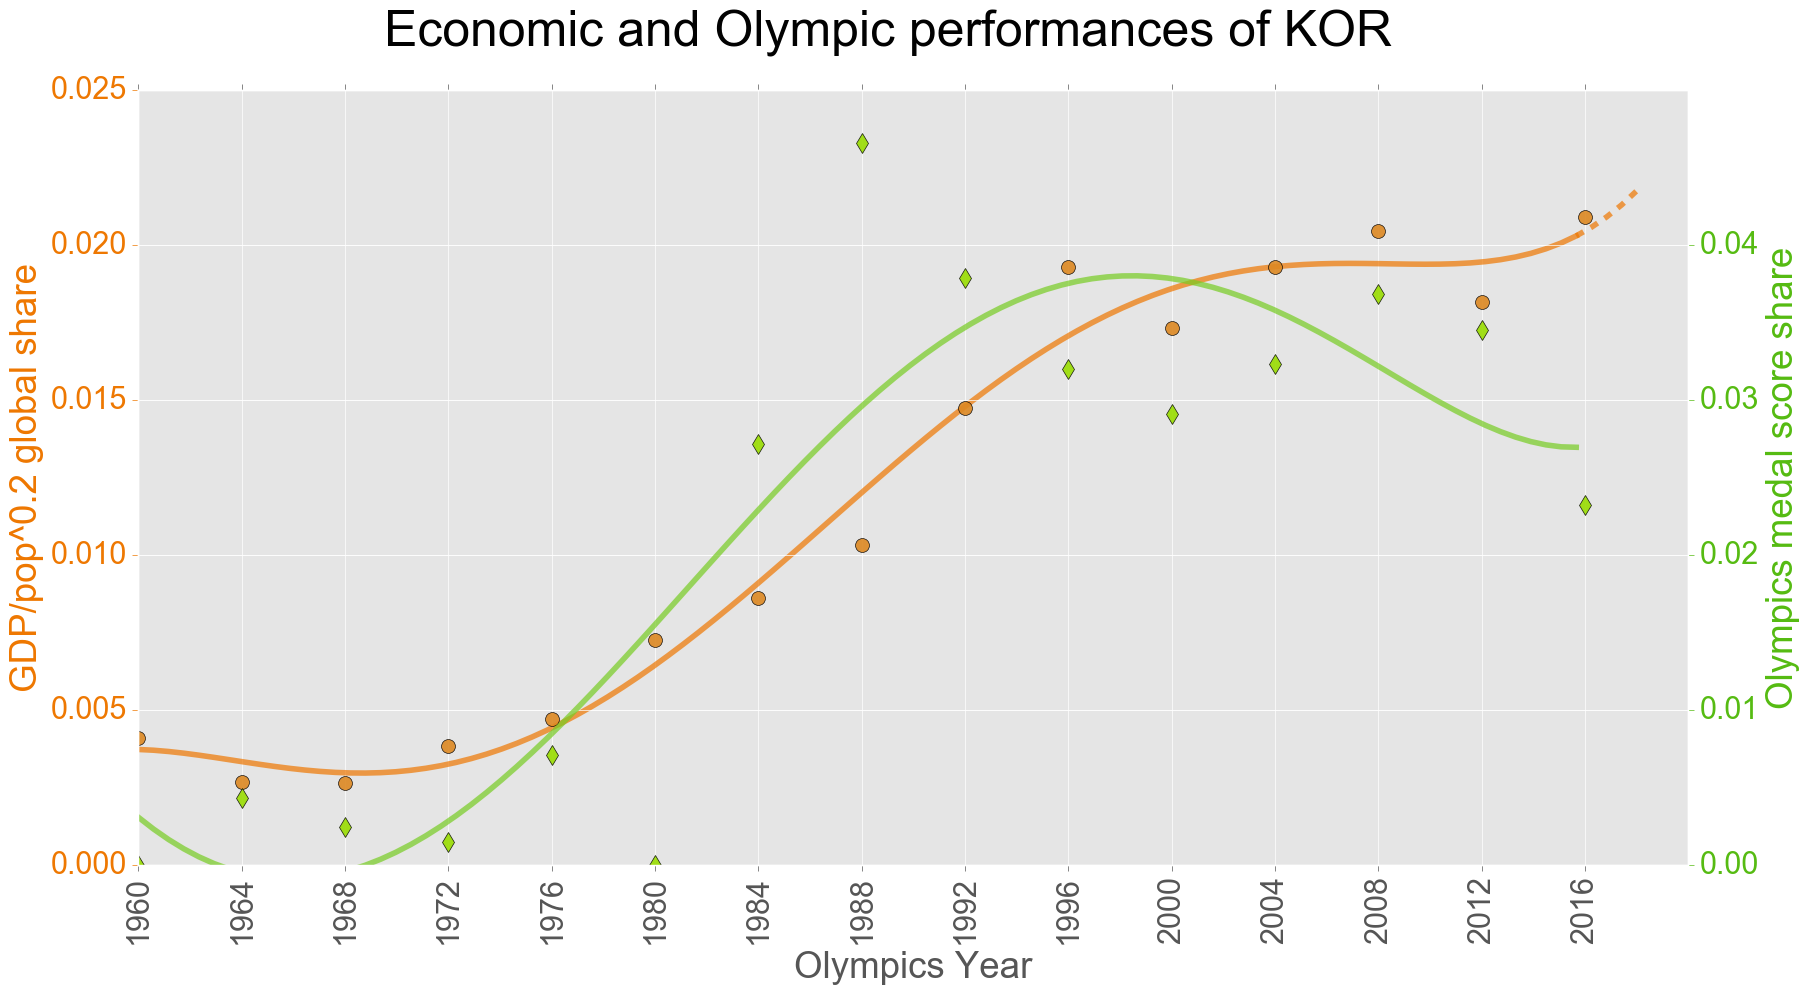

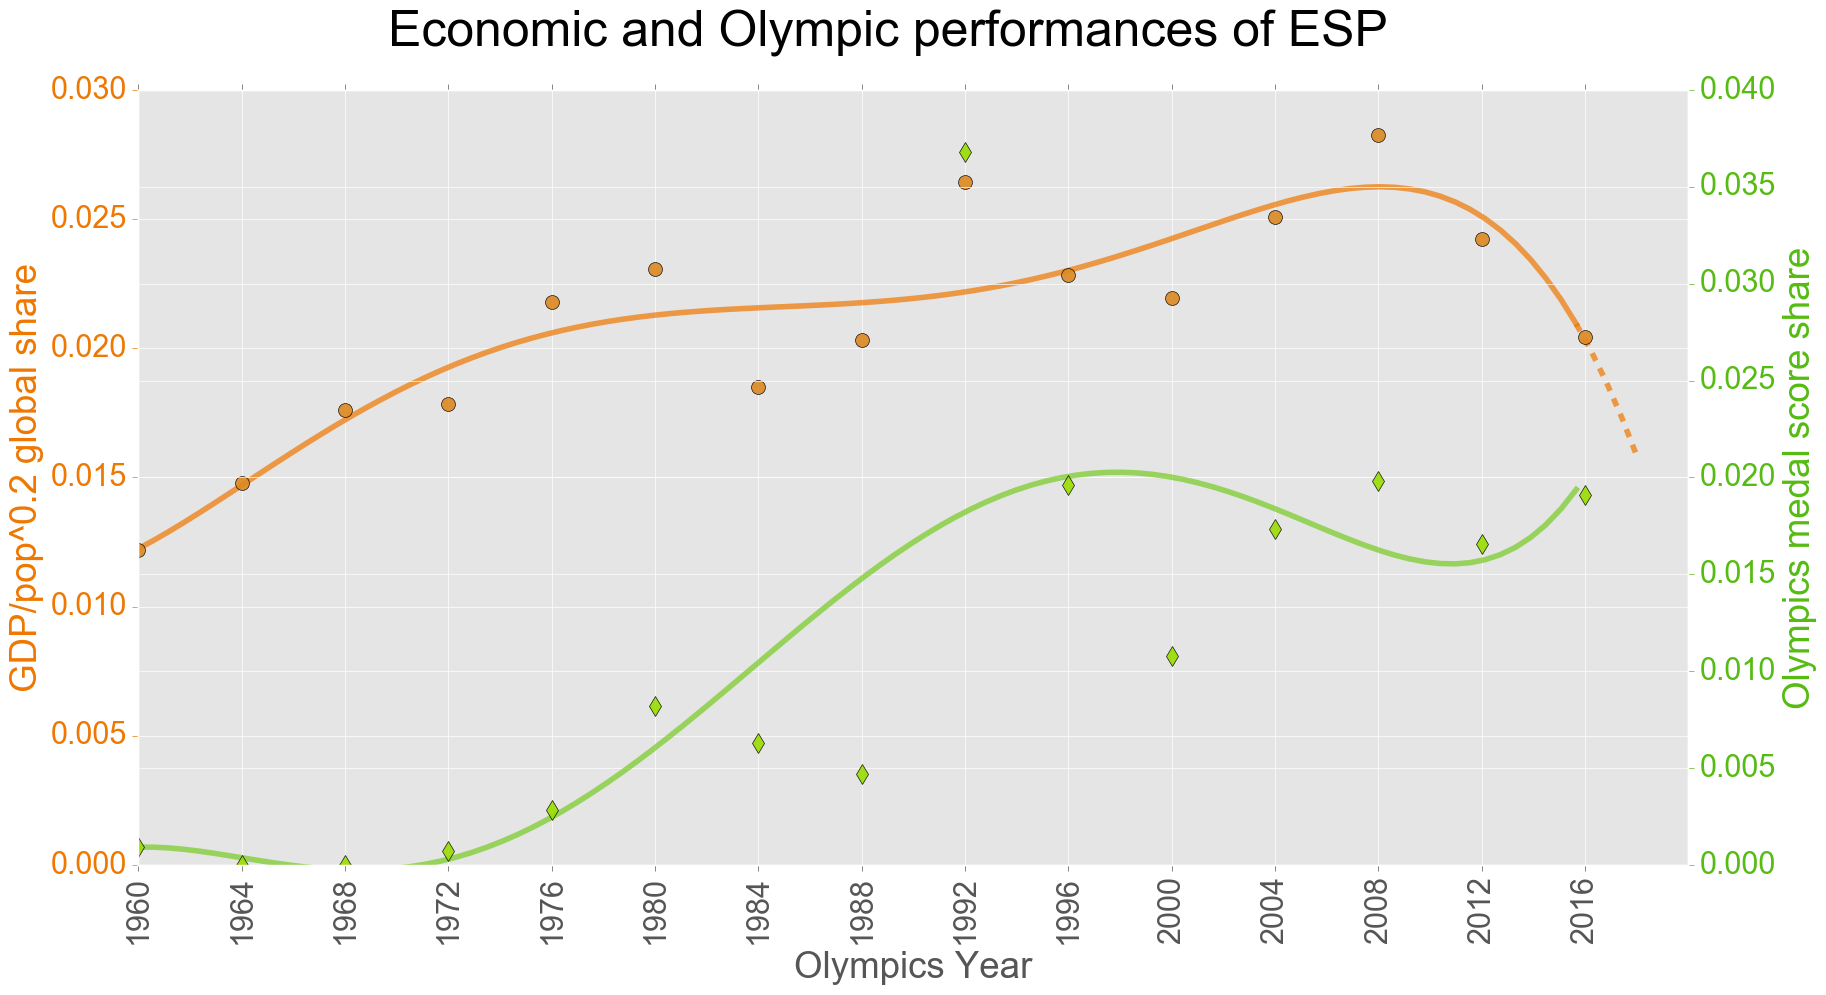

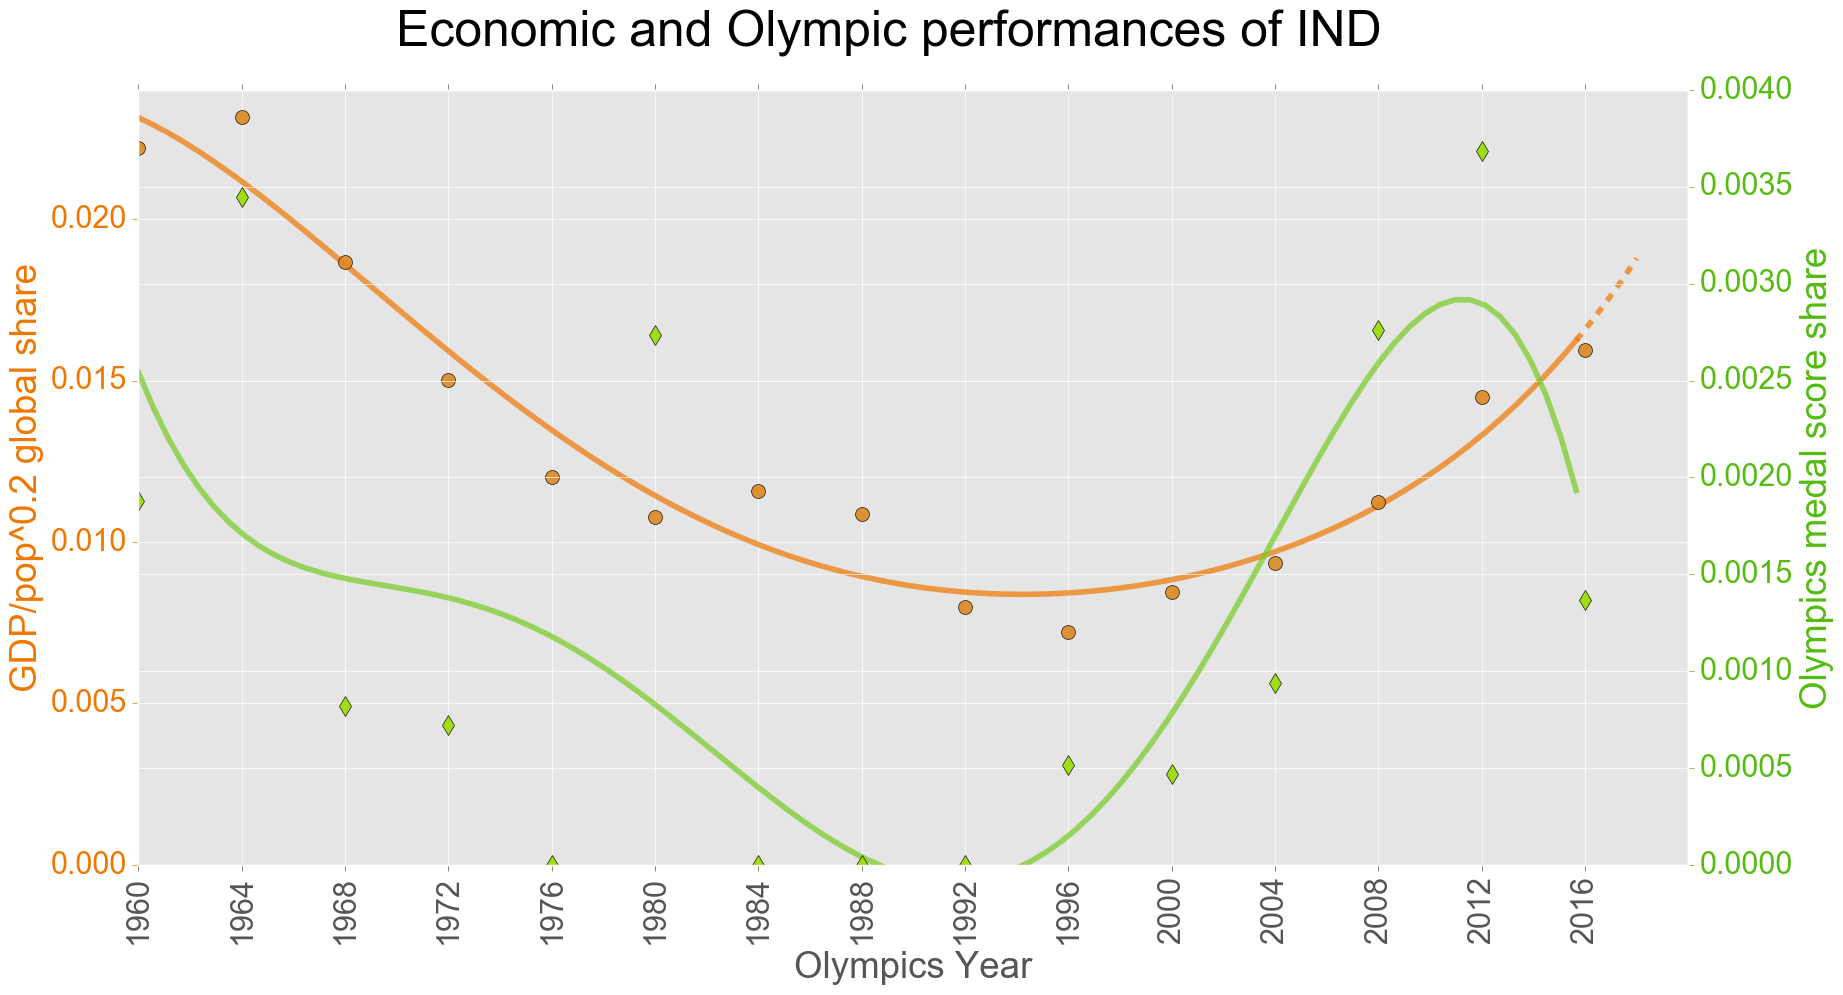

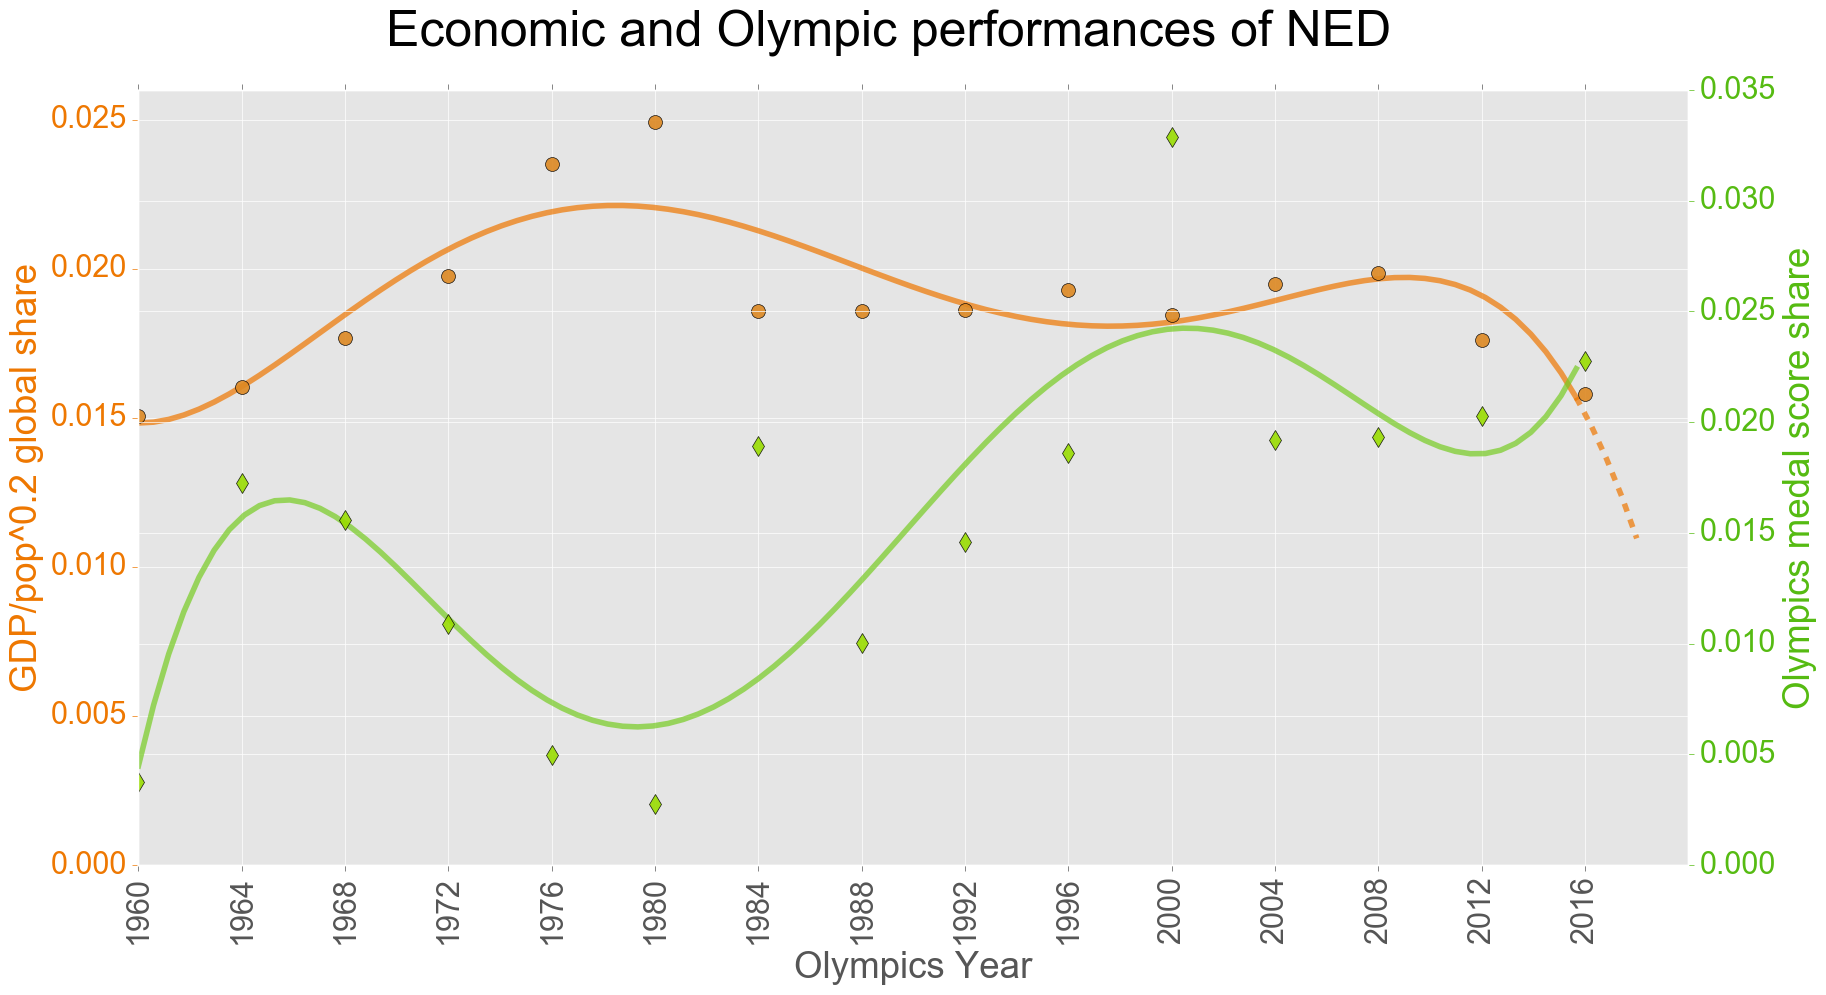

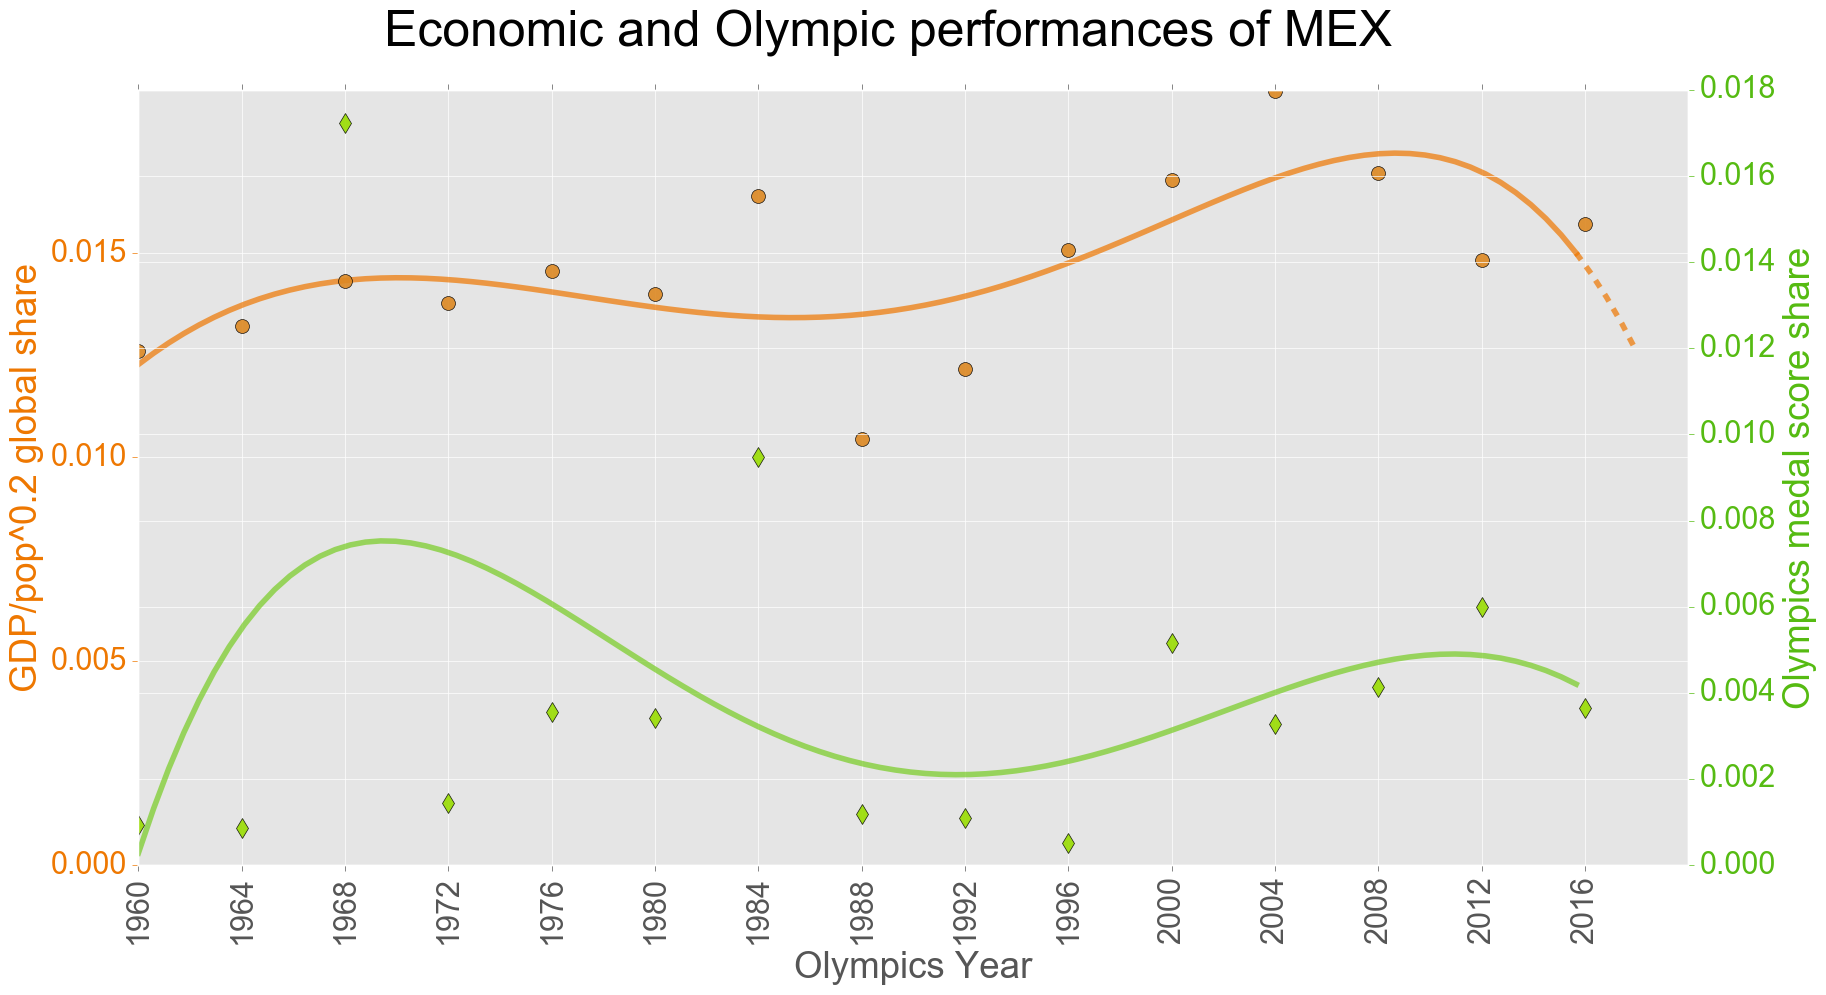

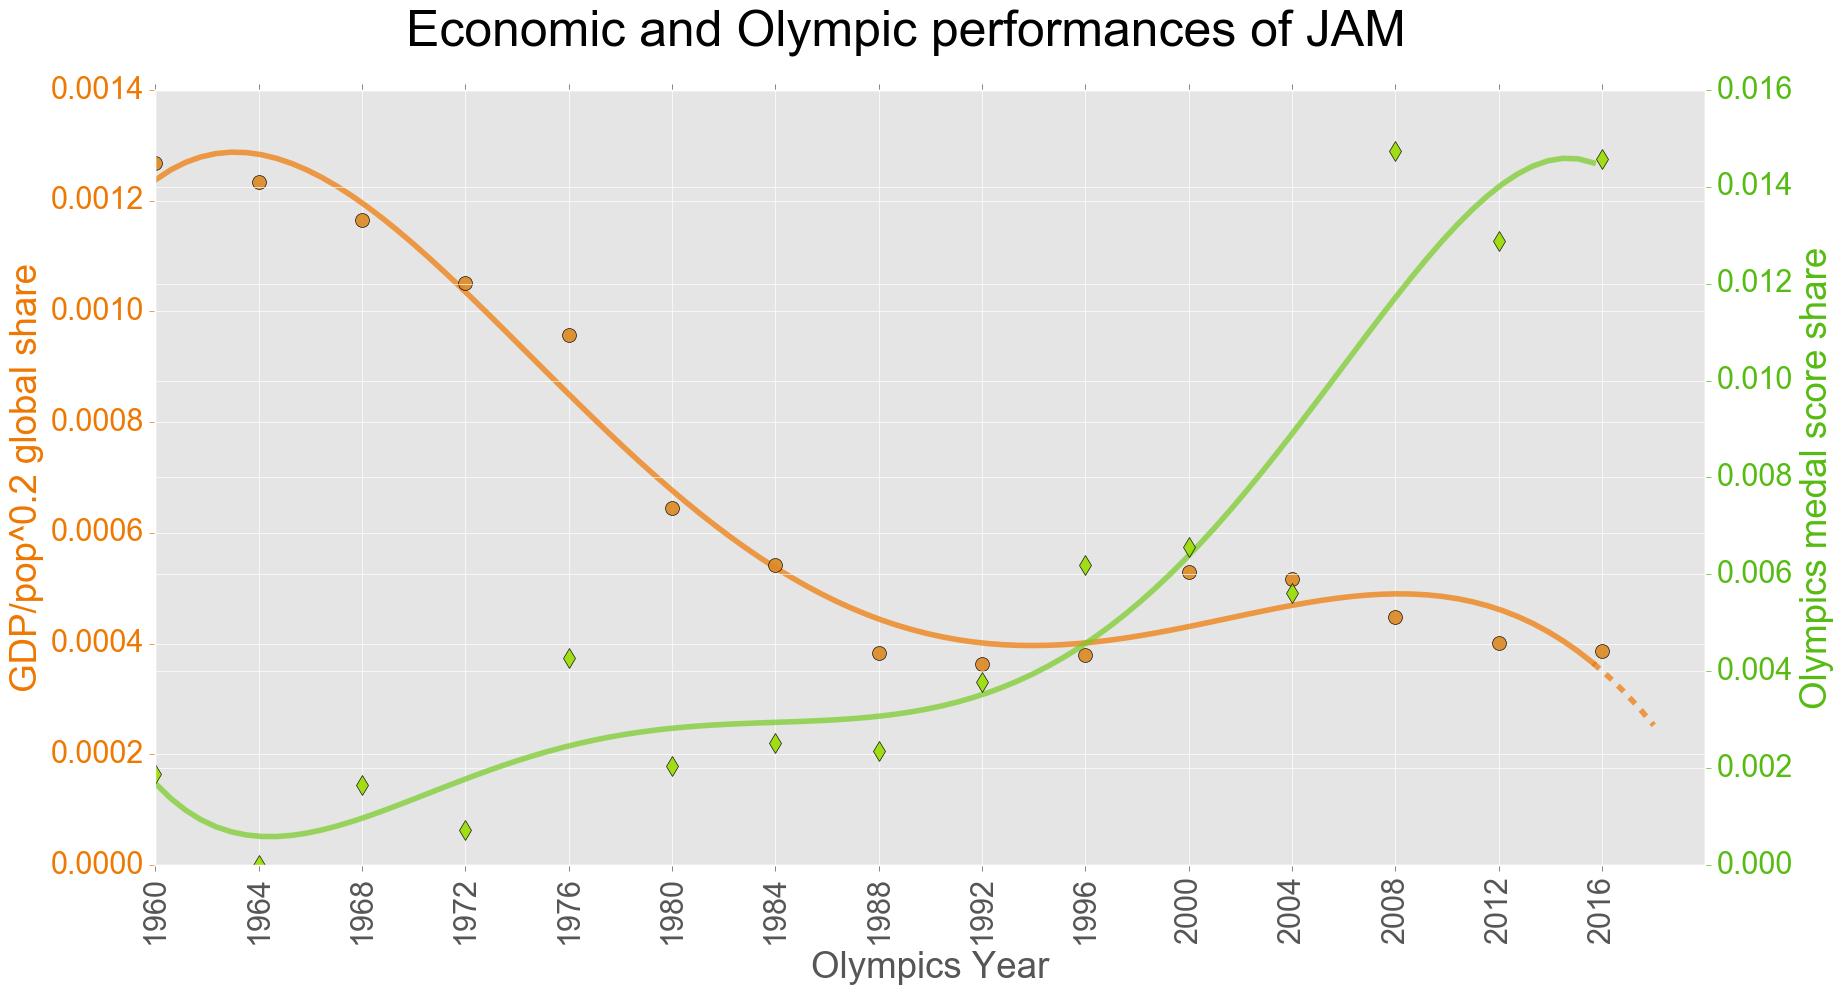

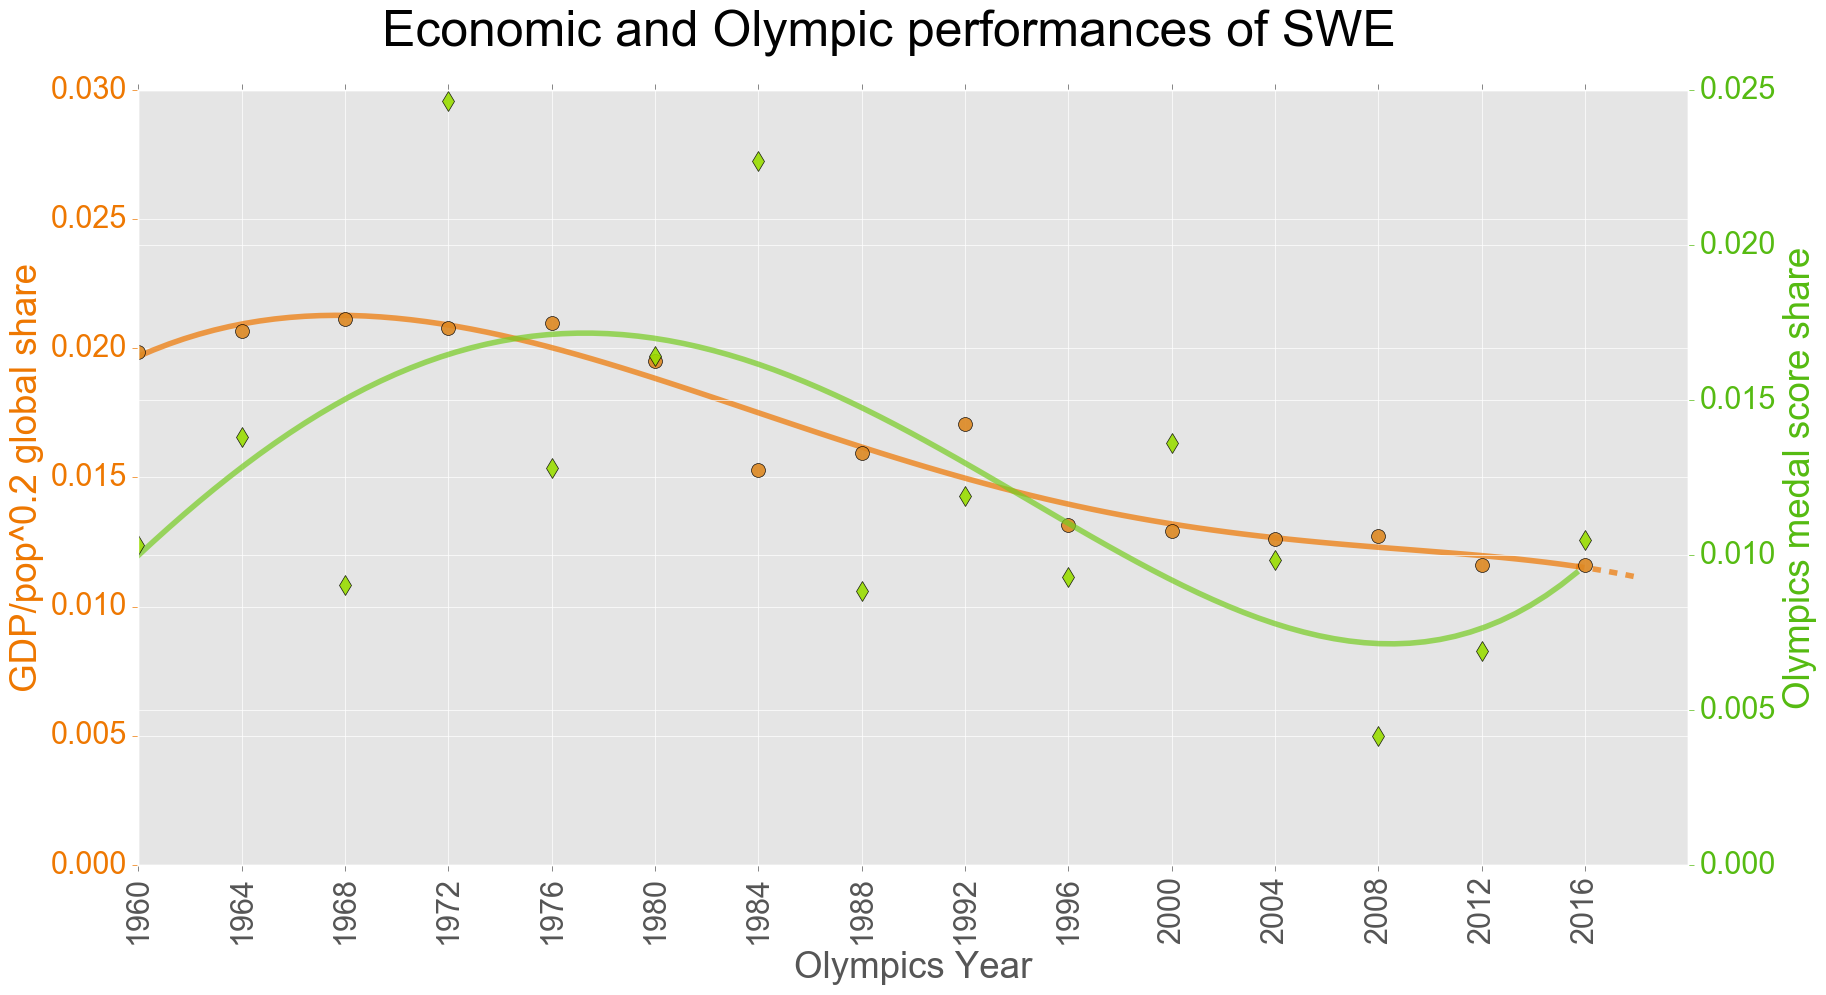

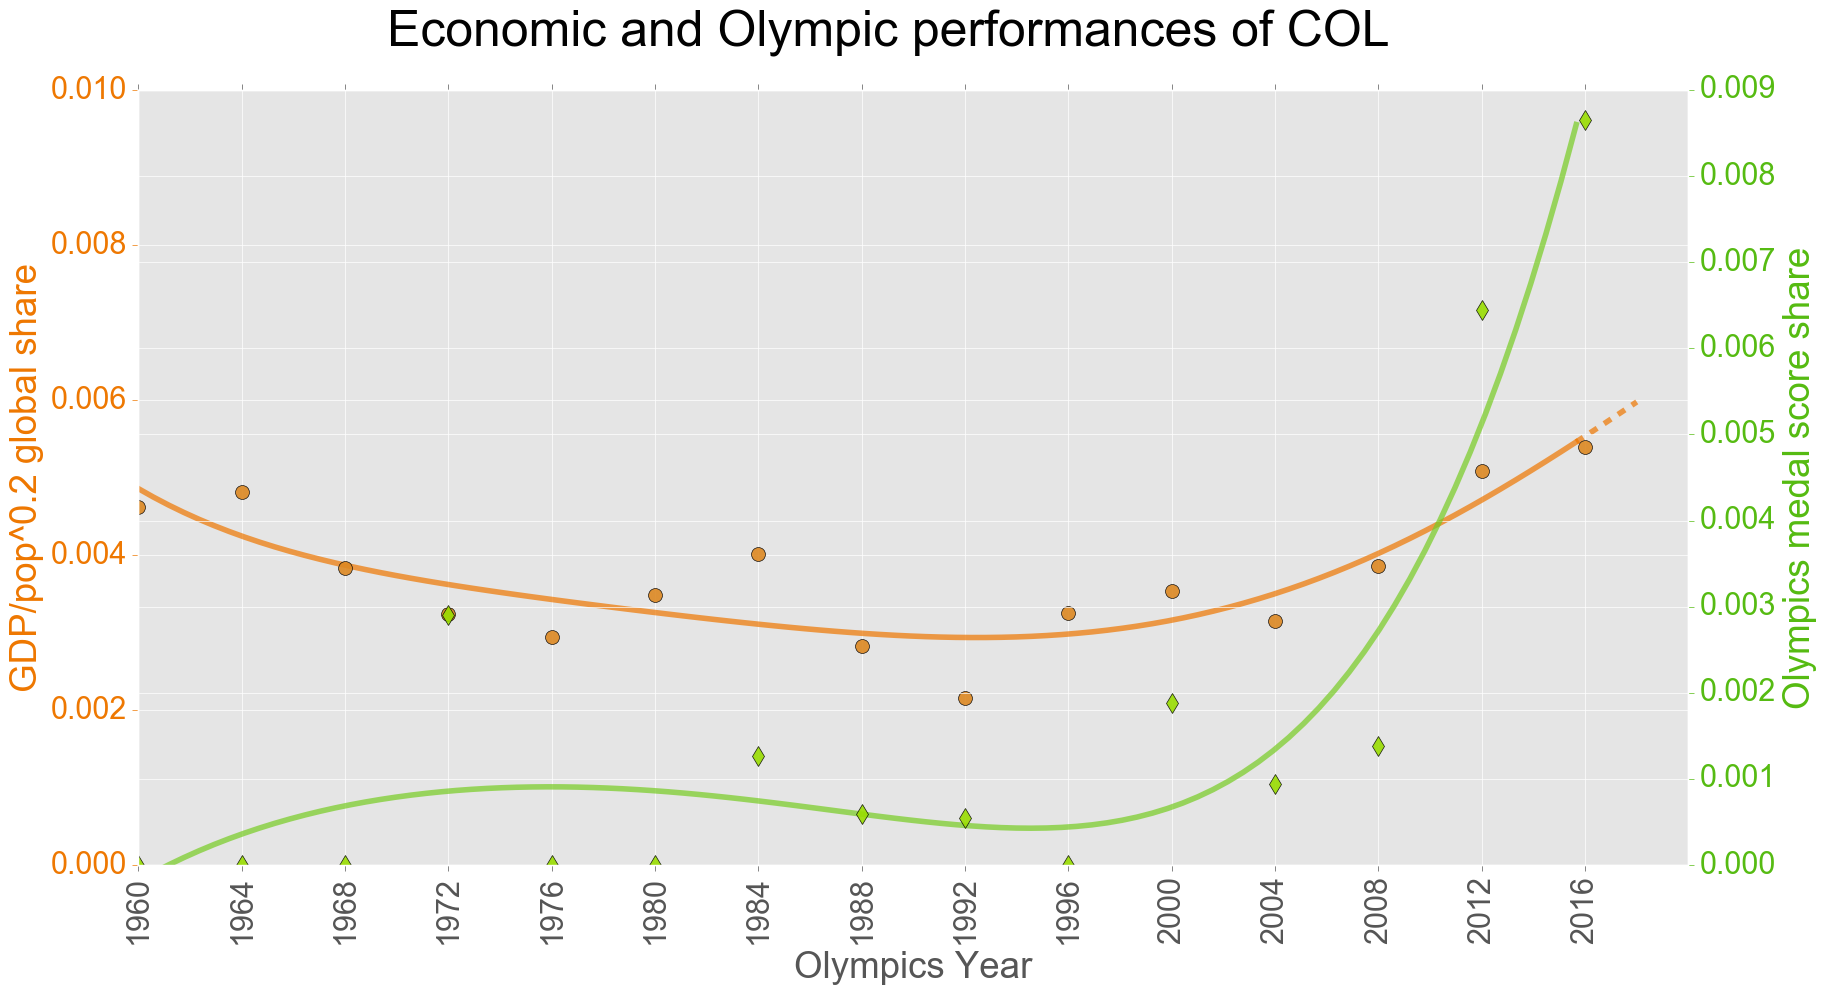

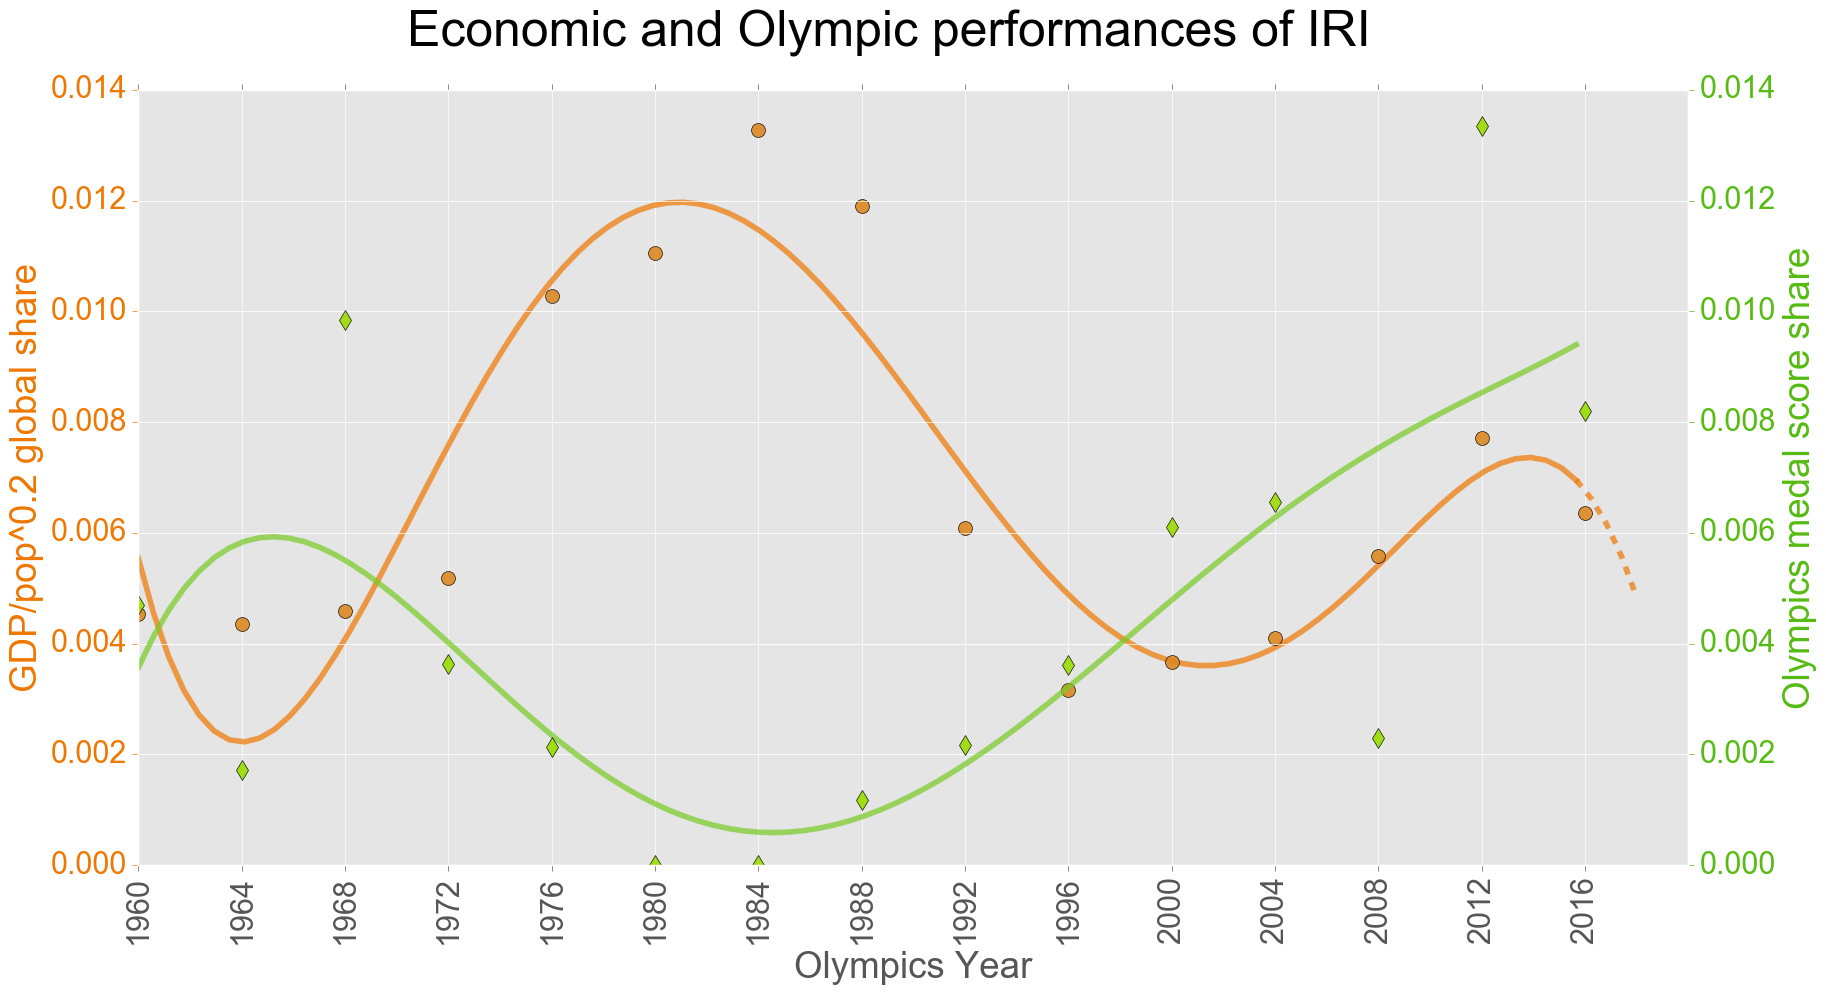

In [10]:
import warnings
warnings.filterwarnings("ignore", category=np.RankWarning)

plot_axes = {}   # dict to hold plot axes for epi-chanegs while plotting them

for country in g3_4y_share_df.index[:16]:  # magic number: 16
    plot_axes[country] = plot_ctr_gdp_olymp_jux ([country])
    plt.show()

#for country in all_shares_top_df.index[:16]:  # magic number: 16
#    plot_axes[country] = plot_ctr_gdp_olymp_jux ([country])

for country in ["JAM","SWE","COL","IRI"]:  # magic number: 16
    plot_axes[country] = plot_ctr_gdp_olymp_jux ([country])


# Rescaling the GDP/pop^0.2 share y-axis to reflect the range of the Olympics y-axis. Units are
    # arbitrary and show relative global share; similar range allows visual judgement of correlation.
plot_axes["USA"][0].set_ybound(upper=0.6)
plot_axes["GER"][0].set_ybound(upper=0.2)
plot_axes["GBR"][0].set_ybound(upper=0.12)
plot_axes["FRA"][0].set_ybound(upper=0.08)
plot_axes["ITA"][0].set_ybound(upper=0.1)
plot_axes["CAN"][0].set_ybound(upper=0.1)
plot_axes["AUS"][0].set_ybound(upper=0.04)
plot_axes["BRA"][0].set_ybound(upper=0.04)
plot_axes["RUS"][0].set_ybound(upper=0.04)
plot_axes["ESP"][0].set_ybound(upper=0.07)
plot_axes["IND"][0].set_ybound(upper=0.03)
plot_axes["NED"][0].set_ybound(upper=0.03)
plot_axes["MEX"][0].set_ybound(upper=0.03)
plot_axes["SWE"][0].set_ybound(upper=0.03)
plot_axes["COL"][0].set_ybound(upper=0.01)


warnings.filterwarnings("default", category=np.RankWarning)



In [ ]:

"""
# TODO: We want, on same plot, a box-whisker graph for each epoch. Identify outliers manually from the top-15 values selected
    # http://matplotlib.org/examples/pylab_examples/boxplot_demo.html
    # http://glowingpython.blogspot.ca/2012/09/boxplot-with-matplotlib.html
    # http://blog.bharatbhole.com/creating-boxplots-with-matplotlib/           Section: Change color ...
# TODO: darker text colors (higher contrast), the box-whiskers, ....
# TODO: For each epoch under each plot note fraction of points (maybe num total and num) of zeros

# TODO: Label missing peaks
# TODO: I think last main todo: Box-whisker plots earlier, give color
# TODO: With the case of Russia in particular: NaN: It seems when grouping in 4 year groups, if any NaN, it declares average NaN.
       It should be more charitable, and take the average of any number of non-NaN values in the group. Maybe the functions takes
       such a parameter
# TODO: Try to compare absolute trends instead of global shares. While global share as a dimension does have intuitive meaning,
       it may be considering too many parameters, like how other countries are doing, ... Compare abcolute gdp vs. Olympic score.

# Do: Olympics graphs for some countries with hosting being influential in their history in the 
    pre-1960 time, especially those who hosted multiple times. Show the hosting peaks: The hosting 
    effect should be exhibited in line graphs directly connecting data points without a curve fit, as 
    the fit usually doesn't follow the hosting boost peak anyway. The graphs can show 2-3 countries on 
    plots like those in the first section in medals_gdp_2.ipynb
# Do: Linear fit to data for some nations like USA with 80% confidence interval, just to show.
# Do: tables of cross-correlations numerically using the scipy function cor(a,b) or en masse, just to 
    show some numbers for results and rank winners with highest correlation. If makes snese visualy, 
    include in report.
# Do: Put all code on GitHub. Correct/enhance comments. Put my name in multiple places.

"""


In [ ]:
"""
The effect of hosting the Olympics on the performance of a nation:

To the credit of the IOC, hosting Olympics raises performance 8 years earlier. It isn't sustainable though as the Olympics performance drops after hosting the event!

GDP not as influential as we hypothesized initially. It's mainly in the sports investment of the nation
For large-economy nations, GDP growth is influential on the Olympics 

- 2 y axes vary scales to match. distinguish with colour which curve is for which axis or arrow (we'll do just 2, so color fine)
- curve fitting as polynomials of lower degrees then going higher to see which matches better, both GDP and Olympics
- do show the data points as like circles or crosses..., points together with the curve fit to the data

period/era, not "epoch"

Report sections:
   0. Method for following for, Olympics system, IOC, My scoring scenario 4,2,1 (better than media
     that suit own nation, e.g. Cananda focus on total number, USA/China/Germany on gold)
   1. one graph like in file 2 line graph
   2. Significance of hosting and line graphs of hosts
   3. GDP-Olympic correlation
   4. Box-whisker plots. Note large number of zeros swaying medians, esp. in the later years, ratio of 0

Report sections:
    - Graphs overall
    - correlation with GDP
    - list of hosts and number of participants
       https://en.wikipedia.org/wiki/List_of_participating_nations_at_the_Summer_Olympic_Games
    - effect of hosting and line graphs
    - box-whisker plots

Report:
- Here are tables showing the top 20 performing nations in GDP/pop^0.2 and Olympics {4,2,1}. As one can
    see, they match in ranking quite well
- There was some correlation of GDP-Olympics, but in some cases, especially smaller economy nations, it
    is less probably true. The most significant determining factor in the Olympics performance was
    hosting of the event, to the credito of the IOC. The hosting is determined about 8 years ahead, and
    from the announcement, the host's Olympic performace improves until the actual hosting year. The
    trend is though not sustained, and the performance falls sharply right after hosting.
- Line plots and box-plots in 5 epochs (of 5 events each except last) show the trends. Narrowing, share
    falls..... Median changes relative to distribution. More countries join. There are 2 box-plots,
    showing zero-medal inclusive and exclusive distributiions. Fraction of zeros are noted.

- If we were to remove the hosting boost to the Olympics score peaks, the correlation would have become 
    much stronger. In some cases, the oost effect is retained (maintained ??), e.g. for Australis and 
    Great Britain.

- GDP-Olymp correlation is good too! Jamaica is bad because it's really focused on sports, especially
    track-and-field, in one person, in particular.




# Method for last part: Metric parameter R was constructed by using tabels for GDPs and populations 
    1960-2015. Tableswere constructed based on the data of GDP/population^m while m varied [0,1]. 
    For each year, each country's R was devided by the total global R of that year. Groups of he table 
    split based on Olympic years (every 4 years) were averaged for comparison with Olympics medals 
    score data.
    Olympics data of 1960-2016 were prepared dtermining a score for each country each year by giving 
    4, 2, and 1 point(s) to each gold, silver, and bronze medal won that year. Annual global shares of 
    the countries' scores were obtained and plotted together with the economy metric data.


# Note: Polynomial fit isn't appropriate naturally, but it was used because it followed well
    the data in its range but omitted irregularities, e.g. boycotting of the Olympics by various
    countries in 1980 and 1984.
# Note: Global shares of both parameters were chosen for correlation. This resulted in the economy metric
    value decreasing for developed countries during the rise of developing nations.
# Note: GDP per capita was considered as well as GDP. GDP per capita ranked placed nations with very
    small populations highest, many city states at the top. It makes sense that among GDP/population^m
    with m [0,1], m smaller in the range would correlate best with Olympics data. 0.2 was a near-pto
    optimum value and used in the analysis.

"""